In [5]:
!pip install kaggle

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content
!unzip -q brats20-dataset-training-validation.zip -d /content/brats2020

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.13G/4.16G [00:37<00:00, 347MB/s]
100% 4.16G/4.16G [00:37<00:00, 119MB/s]


In [10]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/brats2020'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013/BraTS20_Training_013_flair.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013/BraTS20_Training_013_t1ce.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013/BraTS20_Training_013_t2.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013/BraTS20_Training_013_seg.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_013/BraTS20_Training_013_t1.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_306/BraTS20_Training_306_t1.nii
/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_

In [11]:
# Brain Tumor Segmentation using ResNet-120 + LSTM
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet101

# Medical Imaging
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Visualization
import cv2
from tqdm import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
# 1. DATASET EXPLORATION AND SETUP
DATASET_PATH = "/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Dataset structure exploration
def explore_dataset_structure():
    """Explore the actual structure of BraTS dataset"""
    print("=== EXPLORING DATASET STRUCTURE ===")

    if not os.path.exists(DATASET_PATH):
        print("Dataset not found!")
        return None, None

    print(f"Dataset root: {DATASET_PATH}")
    root_contents = os.listdir(DATASET_PATH)
    print(f"Root contents: {root_contents}")

    # searching for the actual patient folders

    train_path = None
    patient_folders = []

    # Search recursively for patient folders containing .nii.gz files
    print("Searching for patient folders with .nii.gz files...")

    for root, dirs, files in os.walk(DATASET_PATH):
        # Check if this directory contains .nii.gz files
        # nii_files = [f for f in files if f.endswith('.nii.gz')]
        nii_files = [f for f in files if f.endswith('.nii.gz') or f.endswith('.nii')]

        if nii_files:
            # This is likely a patient folder
            patient_folder_name = os.path.basename(root)
            parent_dir = os.path.dirname(root)

            if patient_folder_name.startswith('BraTS'):
                if train_path is None:
                    train_path = parent_dir
                    print(f"Found training data directory: {train_path}")

                patient_folders.append(patient_folder_name)
                print(f"Found patient folder: {patient_folder_name} with {len(nii_files)} .nii.gz files")

                # Show files in first patient folder
                if len(patient_folders) == 1:
                    print(f"Sample files in {patient_folder_name}:")
                    for f in nii_files[:10]:  # Show first 10 files
                        print(f"  {f}")

    if train_path and patient_folders:
        print(f"\nSUMMARY:")
        print(f"Training data path: {train_path}")
        print(f"Total patient folders found: {len(patient_folders)}")
        print(f"Sample patients: {patient_folders[:5]}")
        return train_path, patient_folders
    else:
        print("Could not find patient folders with .nii.gz files!")

        # Let's explore the structure manually
        print("\nManual exploration:")
        base_train_path = os.path.join(DATASET_PATH, "BraTS2020_TrainingData")
        if os.path.exists(base_train_path):
            print(f"Contents of {base_train_path}:")
            for item in os.listdir(base_train_path):
                item_path = os.path.join(base_train_path, item)
                if os.path.isdir(item_path):
                    print(f"  Directory: {item}")
                    sub_contents = os.listdir(item_path)[:10]  # First 10 items
                    for sub_item in sub_contents:
                        sub_path = os.path.join(item_path, sub_item)
                        if os.path.isdir(sub_path):
                            print(f"    Subdirectory: {sub_item}")
                            # Check if this contains .nii.gz files
                            try:
                                files_in_sub = os.listdir(sub_path)
                                nii_count = len([f for f in files_in_sub if f.endswith('.nii.gz')])
                                if nii_count > 0:
                                    print(f"      Contains {nii_count} .nii.gz files")
                                    return sub_path if train_path is None else train_path, [sub_item]
                            except:
                                pass

        return None, None

# Run exploration
train_path, patient_folders = explore_dataset_structure()

=== EXPLORING DATASET STRUCTURE ===
Dataset root: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Root contents: ['BraTS20_Training_013', 'BraTS20_Training_306', 'BraTS20_Training_332', 'BraTS20_Training_161', 'BraTS20_Training_129', 'BraTS20_Training_164', 'BraTS20_Training_139', 'BraTS20_Training_206', 'BraTS20_Training_283', 'BraTS20_Training_089', 'BraTS20_Training_070', 'BraTS20_Training_005', 'BraTS20_Training_072', 'BraTS20_Training_256', 'BraTS20_Training_217', 'BraTS20_Training_296', 'BraTS20_Training_245', 'BraTS20_Training_222', 'BraTS20_Training_186', 'BraTS20_Training_014', 'BraTS20_Training_328', 'BraTS20_Training_169', 'BraTS20_Training_056', 'BraTS20_Training_250', 'BraTS20_Training_018', 'BraTS20_Training_099', 'BraTS20_Training_093', 'BraTS20_Training_027', 'BraTS20_Training_356', 'BraTS20_Training_120', 'BraTS20_Training_232', 'BraTS20_Training_331', 'BraTS20_Training_108', 'BraTS20_Training_238', 'BraTS20_Training_137', 'BraTS20_Training_263'

In [13]:

class BraTSDataLoader:
    def __init__(self, data_path, subset_size=10):
        """
        Initialize BraTS data loader
        Args:
            data_path: Path to BraTS training data
            subset_size: Number of patients to use (for memory constraints)
        """

        self.data_path = data_path
        self.subset_size = subset_size

        # Get actual patient folders
        all_folders = os.listdir(data_path) if os.path.exists(data_path) else []
        self.patient_folders = [f for f in all_folders if 'BraTS' in f][:subset_size]
        print("Patient folders being used:", self.patient_folders)
        print(f"Using {len(self.patient_folders)} patients for training")

        if not self.patient_folders:
            print("No patient folders found!")
            return

        # Auto-detect file naming pattern
        self.file_pattern = self._detect_file_pattern()

    def _detect_file_pattern(self):
        """Auto-detect the file naming pattern in BraTS dataset"""
        if not self.patient_folders:
            return None
        sample_patient = self.patient_folders[0]
        sample_path = os.path.join(self.data_path, sample_patient)

        if not os.path.exists(sample_path):
            return None
        files = os.listdir(sample_path)
        nii_files = [f for f in files if f.endswith('.nii') or f.endswith('.nii.gz')]
        print(f"Sample patient files: {nii_files}")
        # Check for standard naming like BraTS20_Training_001_flair.nii.gz
        test_file_nii = f"{sample_patient}_flair.nii"
        test_file_nizz = f"{sample_patient}_flair.nii.gz"
        if test_file_nii in nii_files or test_file_niigz in nii_files:
            print("Detected standard BraTS naming convention.")
            return lambda patient_id, modality: f"{patient_id}_{modality}.nii.gz"
		# Otherwise fallback to flexible pattern matching
        else:
            print("Using flexible file pattern matching.")
            return lambda patient_id, modality: self._find_modality_file(
            os.path.join(self.data_path, patient_id), modality
    )
    def _find_modality_file(self, patient_path, modality):
        """Find file by modality name in the filename"""
        files = os.listdir(patient_path)
        for file in files:
            if modality.lower() in file.lower() and file.endswith('.nii.gz'):
                return file
        return None

    def _flexible_pattern(self, patient_id, modality):
        """Flexible pattern matching"""
        patient_path = os.path.join(self.data_path, patient_id)
        return self._find_modality_file(patient_path, modality)

    def load_patient_data(self, patient_id):
        """Load all modalities for a single patient"""
        patient_path = os.path.join(self.data_path, patient_id)

        if not os.path.exists(patient_path):
            print(f"Patient path not found: {patient_path}")
            return {}

        # Try to find files for each modality
        modalities = ['flair', 't1', 't1ce', 't2', 'seg']
        files = {}

        for modality in modalities:
            filename = None
            if self.file_pattern:
                filename = self.file_pattern(patient_id, modality)
                if filename:
                    # filepath = os.path.join(patient_path, filename)
                    nii_gz_path = os.path.join(patient_path, filename)
                    nii_path = nii_gz_path.replace(".nii.gz", ".nii")
                    if os.path.exists(nii_gz_path):
                        files[modality] = nii_gz_path
                    elif os.path.exists(nii_path):
                        files[modality] = nii_path
                    else:
                        print(f"[Missing] {modality.upper()} not found at {nii_gz_path} or {nii_path}")
                else:
                    print(f"[Pattern Fail] Could not generate filename for {modality} using pattern.")

        # Load the data
        data = {}
        for modality, filepath in files.items():
            try:
                nii_img = nib.load(filepath)
                data[modality] = nii_img.get_fdata()
                print(f"Loaded {modality}: {data[modality].shape}")
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

        return data

    def preprocess_volume(self, volume, target_size=(128, 128), is_mask=False):
        """Preprocess 3D volume to 2D slices"""
        # Normalize to 0-1 range
        if not is_mask:
            volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)

        processed_slices = []
        for slice_idx in range(volume.shape[2]):
            slice_2d = volume[:, :, slice_idx]

            # Resize slice
            if is_mask:
                slice_resized = cv2.resize(slice_2d, target_size, interpolation=cv2.INTER_NEAREST)
            else:
                slice_resized = cv2.resize(slice_2d, target_size, interpolation=cv2.INTER_LINEAR)

            processed_slices.append(slice_resized)

        return np.array(processed_slices)

    def create_dataset(self):
        """Create dataset with all patients"""
        all_sequences = []
        all_masks = []

        for patient_id in tqdm(self.patient_folders, desc="Processing patients"):
            try:
                patient_data = self.load_patient_data(patient_id)

                if all(mod in patient_data for mod in ['flair', 't1ce', 'seg']):
                    # Process each modality
                    flair_slices = self.preprocess_volume(patient_data['flair'])
                    t1ce_slices = self.preprocess_volume(patient_data['t1ce'])
                    seg_slices = self.preprocess_volume(patient_data['seg'], is_mask=True)
                    seg_slices[seg_slices == 4] = 3
                    # Combine modalities (using FLAIR and T1CE as example)
                    combined_slices = np.stack([flair_slices, t1ce_slices], axis=1)

                    # Filter out empty slices (slices with no tumor)
                    for i in range(len(seg_slices)):
                        print(f"[{patient_id}] Slice {i} sum: {np.sum(seg_slices[i])}")
                        # if np.sum(seg_slices[i]) > 0:  # Has tumor pixels
                        all_sequences.append(combined_slices[i])
                        all_masks.append(seg_slices[i])

            except Exception as e:
                print(f"Error processing {patient_id}: {e}")
                continue

        return np.array(all_sequences), np.array(all_masks)

In [14]:
# Initialize with 50 patients
data_loader = BraTSDataLoader(data_path=train_path, subset_size=10)

# Actually load and preprocess the data
sequences, masks = data_loader.create_dataset()

# Print summarys
print(f"\n Final dataset shapes:")
print(f"Sequences shape: {sequences.shape}")
print(f"Masks shape: {masks.shape}")


Patient folders being used: ['BraTS20_Training_013', 'BraTS20_Training_306', 'BraTS20_Training_332', 'BraTS20_Training_161', 'BraTS20_Training_129', 'BraTS20_Training_164', 'BraTS20_Training_139', 'BraTS20_Training_206', 'BraTS20_Training_283', 'BraTS20_Training_089']
Using 10 patients for training
Sample patient files: ['BraTS20_Training_013_flair.nii', 'BraTS20_Training_013_t1ce.nii', 'BraTS20_Training_013_t2.nii', 'BraTS20_Training_013_seg.nii', 'BraTS20_Training_013_t1.nii']
✅ Detected standard BraTS naming convention.


Processing patients:   0%|          | 0/10 [00:00<?, ?it/s]

Loaded flair: (240, 240, 155)
Loaded t1: (240, 240, 155)
Loaded t1ce: (240, 240, 155)
Loaded t2: (240, 240, 155)
Loaded seg: (240, 240, 155)


Processing patients:  10%|█         | 1/10 [00:01<00:09,  1.06s/it]

[BraTS20_Training_013] Slice 0 sum: 0.0
[BraTS20_Training_013] Slice 1 sum: 0.0
[BraTS20_Training_013] Slice 2 sum: 0.0
[BraTS20_Training_013] Slice 3 sum: 0.0
[BraTS20_Training_013] Slice 4 sum: 0.0
[BraTS20_Training_013] Slice 5 sum: 0.0
[BraTS20_Training_013] Slice 6 sum: 0.0
[BraTS20_Training_013] Slice 7 sum: 0.0
[BraTS20_Training_013] Slice 8 sum: 0.0
[BraTS20_Training_013] Slice 9 sum: 0.0
[BraTS20_Training_013] Slice 10 sum: 0.0
[BraTS20_Training_013] Slice 11 sum: 0.0
[BraTS20_Training_013] Slice 12 sum: 0.0
[BraTS20_Training_013] Slice 13 sum: 0.0
[BraTS20_Training_013] Slice 14 sum: 0.0
[BraTS20_Training_013] Slice 15 sum: 0.0
[BraTS20_Training_013] Slice 16 sum: 0.0
[BraTS20_Training_013] Slice 17 sum: 0.0
[BraTS20_Training_013] Slice 18 sum: 0.0
[BraTS20_Training_013] Slice 19 sum: 0.0
[BraTS20_Training_013] Slice 20 sum: 0.0
[BraTS20_Training_013] Slice 21 sum: 0.0
[BraTS20_Training_013] Slice 22 sum: 0.0
[BraTS20_Training_013] Slice 23 sum: 0.0
[BraTS20_Training_013] Sli

Processing patients:  20%|██        | 2/10 [00:01<00:07,  1.05it/s]

[BraTS20_Training_306] Slice 0 sum: 0.0
[BraTS20_Training_306] Slice 1 sum: 0.0
[BraTS20_Training_306] Slice 2 sum: 0.0
[BraTS20_Training_306] Slice 3 sum: 0.0
[BraTS20_Training_306] Slice 4 sum: 0.0
[BraTS20_Training_306] Slice 5 sum: 0.0
[BraTS20_Training_306] Slice 6 sum: 0.0
[BraTS20_Training_306] Slice 7 sum: 0.0
[BraTS20_Training_306] Slice 8 sum: 0.0
[BraTS20_Training_306] Slice 9 sum: 0.0
[BraTS20_Training_306] Slice 10 sum: 0.0
[BraTS20_Training_306] Slice 11 sum: 0.0
[BraTS20_Training_306] Slice 12 sum: 0.0
[BraTS20_Training_306] Slice 13 sum: 0.0
[BraTS20_Training_306] Slice 14 sum: 0.0
[BraTS20_Training_306] Slice 15 sum: 0.0
[BraTS20_Training_306] Slice 16 sum: 0.0
[BraTS20_Training_306] Slice 17 sum: 0.0
[BraTS20_Training_306] Slice 18 sum: 0.0
[BraTS20_Training_306] Slice 19 sum: 0.0
[BraTS20_Training_306] Slice 20 sum: 0.0
[BraTS20_Training_306] Slice 21 sum: 0.0
[BraTS20_Training_306] Slice 22 sum: 0.0
[BraTS20_Training_306] Slice 23 sum: 0.0
[BraTS20_Training_306] Sli

Processing patients:  30%|███       | 3/10 [00:02<00:06,  1.13it/s]

[BraTS20_Training_332] Slice 0 sum: 0.0
[BraTS20_Training_332] Slice 1 sum: 0.0
[BraTS20_Training_332] Slice 2 sum: 0.0
[BraTS20_Training_332] Slice 3 sum: 0.0
[BraTS20_Training_332] Slice 4 sum: 0.0
[BraTS20_Training_332] Slice 5 sum: 0.0
[BraTS20_Training_332] Slice 6 sum: 0.0
[BraTS20_Training_332] Slice 7 sum: 0.0
[BraTS20_Training_332] Slice 8 sum: 0.0
[BraTS20_Training_332] Slice 9 sum: 0.0
[BraTS20_Training_332] Slice 10 sum: 0.0
[BraTS20_Training_332] Slice 11 sum: 0.0
[BraTS20_Training_332] Slice 12 sum: 0.0
[BraTS20_Training_332] Slice 13 sum: 0.0
[BraTS20_Training_332] Slice 14 sum: 0.0
[BraTS20_Training_332] Slice 15 sum: 0.0
[BraTS20_Training_332] Slice 16 sum: 0.0
[BraTS20_Training_332] Slice 17 sum: 0.0
[BraTS20_Training_332] Slice 18 sum: 0.0
[BraTS20_Training_332] Slice 19 sum: 0.0
[BraTS20_Training_332] Slice 20 sum: 0.0
[BraTS20_Training_332] Slice 21 sum: 0.0
[BraTS20_Training_332] Slice 22 sum: 0.0
[BraTS20_Training_332] Slice 23 sum: 0.0
[BraTS20_Training_332] Sli

Processing patients:  40%|████      | 4/10 [00:03<00:04,  1.25it/s]

[BraTS20_Training_161] Slice 0 sum: 0.0
[BraTS20_Training_161] Slice 1 sum: 0.0
[BraTS20_Training_161] Slice 2 sum: 0.0
[BraTS20_Training_161] Slice 3 sum: 0.0
[BraTS20_Training_161] Slice 4 sum: 0.0
[BraTS20_Training_161] Slice 5 sum: 0.0
[BraTS20_Training_161] Slice 6 sum: 0.0
[BraTS20_Training_161] Slice 7 sum: 0.0
[BraTS20_Training_161] Slice 8 sum: 0.0
[BraTS20_Training_161] Slice 9 sum: 0.0
[BraTS20_Training_161] Slice 10 sum: 0.0
[BraTS20_Training_161] Slice 11 sum: 0.0
[BraTS20_Training_161] Slice 12 sum: 0.0
[BraTS20_Training_161] Slice 13 sum: 0.0
[BraTS20_Training_161] Slice 14 sum: 0.0
[BraTS20_Training_161] Slice 15 sum: 0.0
[BraTS20_Training_161] Slice 16 sum: 0.0
[BraTS20_Training_161] Slice 17 sum: 0.0
[BraTS20_Training_161] Slice 18 sum: 0.0
[BraTS20_Training_161] Slice 19 sum: 0.0
[BraTS20_Training_161] Slice 20 sum: 0.0
[BraTS20_Training_161] Slice 21 sum: 0.0
[BraTS20_Training_161] Slice 22 sum: 0.0
[BraTS20_Training_161] Slice 23 sum: 0.0
[BraTS20_Training_161] Sli

Processing patients:  50%|█████     | 5/10 [00:04<00:03,  1.31it/s]

[BraTS20_Training_129] Slice 0 sum: 0.0
[BraTS20_Training_129] Slice 1 sum: 0.0
[BraTS20_Training_129] Slice 2 sum: 0.0
[BraTS20_Training_129] Slice 3 sum: 0.0
[BraTS20_Training_129] Slice 4 sum: 0.0
[BraTS20_Training_129] Slice 5 sum: 0.0
[BraTS20_Training_129] Slice 6 sum: 0.0
[BraTS20_Training_129] Slice 7 sum: 0.0
[BraTS20_Training_129] Slice 8 sum: 0.0
[BraTS20_Training_129] Slice 9 sum: 0.0
[BraTS20_Training_129] Slice 10 sum: 0.0
[BraTS20_Training_129] Slice 11 sum: 0.0
[BraTS20_Training_129] Slice 12 sum: 0.0
[BraTS20_Training_129] Slice 13 sum: 0.0
[BraTS20_Training_129] Slice 14 sum: 0.0
[BraTS20_Training_129] Slice 15 sum: 0.0
[BraTS20_Training_129] Slice 16 sum: 0.0
[BraTS20_Training_129] Slice 17 sum: 0.0
[BraTS20_Training_129] Slice 18 sum: 0.0
[BraTS20_Training_129] Slice 19 sum: 0.0
[BraTS20_Training_129] Slice 20 sum: 0.0
[BraTS20_Training_129] Slice 21 sum: 0.0
[BraTS20_Training_129] Slice 22 sum: 0.0
[BraTS20_Training_129] Slice 23 sum: 0.0
[BraTS20_Training_129] Sli

Processing patients:  60%|██████    | 6/10 [00:04<00:02,  1.34it/s]

[BraTS20_Training_164] Slice 0 sum: 0.0
[BraTS20_Training_164] Slice 1 sum: 0.0
[BraTS20_Training_164] Slice 2 sum: 0.0
[BraTS20_Training_164] Slice 3 sum: 0.0
[BraTS20_Training_164] Slice 4 sum: 0.0
[BraTS20_Training_164] Slice 5 sum: 0.0
[BraTS20_Training_164] Slice 6 sum: 0.0
[BraTS20_Training_164] Slice 7 sum: 0.0
[BraTS20_Training_164] Slice 8 sum: 0.0
[BraTS20_Training_164] Slice 9 sum: 0.0
[BraTS20_Training_164] Slice 10 sum: 0.0
[BraTS20_Training_164] Slice 11 sum: 0.0
[BraTS20_Training_164] Slice 12 sum: 0.0
[BraTS20_Training_164] Slice 13 sum: 0.0
[BraTS20_Training_164] Slice 14 sum: 0.0
[BraTS20_Training_164] Slice 15 sum: 0.0
[BraTS20_Training_164] Slice 16 sum: 0.0
[BraTS20_Training_164] Slice 17 sum: 0.0
[BraTS20_Training_164] Slice 18 sum: 0.0
[BraTS20_Training_164] Slice 19 sum: 0.0
[BraTS20_Training_164] Slice 20 sum: 0.0
[BraTS20_Training_164] Slice 21 sum: 0.0
[BraTS20_Training_164] Slice 22 sum: 0.0
[BraTS20_Training_164] Slice 23 sum: 0.0
[BraTS20_Training_164] Sli

Processing patients:  70%|███████   | 7/10 [00:05<00:02,  1.36it/s]

[BraTS20_Training_139] Slice 0 sum: 0.0
[BraTS20_Training_139] Slice 1 sum: 0.0
[BraTS20_Training_139] Slice 2 sum: 0.0
[BraTS20_Training_139] Slice 3 sum: 0.0
[BraTS20_Training_139] Slice 4 sum: 0.0
[BraTS20_Training_139] Slice 5 sum: 0.0
[BraTS20_Training_139] Slice 6 sum: 0.0
[BraTS20_Training_139] Slice 7 sum: 0.0
[BraTS20_Training_139] Slice 8 sum: 0.0
[BraTS20_Training_139] Slice 9 sum: 0.0
[BraTS20_Training_139] Slice 10 sum: 0.0
[BraTS20_Training_139] Slice 11 sum: 0.0
[BraTS20_Training_139] Slice 12 sum: 0.0
[BraTS20_Training_139] Slice 13 sum: 0.0
[BraTS20_Training_139] Slice 14 sum: 0.0
[BraTS20_Training_139] Slice 15 sum: 0.0
[BraTS20_Training_139] Slice 16 sum: 0.0
[BraTS20_Training_139] Slice 17 sum: 0.0
[BraTS20_Training_139] Slice 18 sum: 0.0
[BraTS20_Training_139] Slice 19 sum: 0.0
[BraTS20_Training_139] Slice 20 sum: 0.0
[BraTS20_Training_139] Slice 21 sum: 0.0
[BraTS20_Training_139] Slice 22 sum: 0.0
[BraTS20_Training_139] Slice 23 sum: 0.0
[BraTS20_Training_139] Sli

Processing patients:  80%|████████  | 8/10 [00:06<00:01,  1.40it/s]

[BraTS20_Training_206] Slice 0 sum: 0.0
[BraTS20_Training_206] Slice 1 sum: 0.0
[BraTS20_Training_206] Slice 2 sum: 0.0
[BraTS20_Training_206] Slice 3 sum: 0.0
[BraTS20_Training_206] Slice 4 sum: 0.0
[BraTS20_Training_206] Slice 5 sum: 0.0
[BraTS20_Training_206] Slice 6 sum: 0.0
[BraTS20_Training_206] Slice 7 sum: 0.0
[BraTS20_Training_206] Slice 8 sum: 0.0
[BraTS20_Training_206] Slice 9 sum: 0.0
[BraTS20_Training_206] Slice 10 sum: 0.0
[BraTS20_Training_206] Slice 11 sum: 0.0
[BraTS20_Training_206] Slice 12 sum: 0.0
[BraTS20_Training_206] Slice 13 sum: 0.0
[BraTS20_Training_206] Slice 14 sum: 0.0
[BraTS20_Training_206] Slice 15 sum: 0.0
[BraTS20_Training_206] Slice 16 sum: 0.0
[BraTS20_Training_206] Slice 17 sum: 0.0
[BraTS20_Training_206] Slice 18 sum: 0.0
[BraTS20_Training_206] Slice 19 sum: 0.0
[BraTS20_Training_206] Slice 20 sum: 0.0
[BraTS20_Training_206] Slice 21 sum: 0.0
[BraTS20_Training_206] Slice 22 sum: 0.0
[BraTS20_Training_206] Slice 23 sum: 0.0
[BraTS20_Training_206] Sli

Processing patients:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

[BraTS20_Training_283] Slice 0 sum: 0.0
[BraTS20_Training_283] Slice 1 sum: 0.0
[BraTS20_Training_283] Slice 2 sum: 0.0
[BraTS20_Training_283] Slice 3 sum: 0.0
[BraTS20_Training_283] Slice 4 sum: 0.0
[BraTS20_Training_283] Slice 5 sum: 0.0
[BraTS20_Training_283] Slice 6 sum: 0.0
[BraTS20_Training_283] Slice 7 sum: 0.0
[BraTS20_Training_283] Slice 8 sum: 0.0
[BraTS20_Training_283] Slice 9 sum: 0.0
[BraTS20_Training_283] Slice 10 sum: 0.0
[BraTS20_Training_283] Slice 11 sum: 0.0
[BraTS20_Training_283] Slice 12 sum: 0.0
[BraTS20_Training_283] Slice 13 sum: 0.0
[BraTS20_Training_283] Slice 14 sum: 0.0
[BraTS20_Training_283] Slice 15 sum: 0.0
[BraTS20_Training_283] Slice 16 sum: 0.0
[BraTS20_Training_283] Slice 17 sum: 0.0
[BraTS20_Training_283] Slice 18 sum: 0.0
[BraTS20_Training_283] Slice 19 sum: 0.0
[BraTS20_Training_283] Slice 20 sum: 0.0
[BraTS20_Training_283] Slice 21 sum: 0.0
[BraTS20_Training_283] Slice 22 sum: 0.0
[BraTS20_Training_283] Slice 23 sum: 0.0
[BraTS20_Training_283] Sli

Processing patients: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

[BraTS20_Training_089] Slice 0 sum: 0.0
[BraTS20_Training_089] Slice 1 sum: 0.0
[BraTS20_Training_089] Slice 2 sum: 0.0
[BraTS20_Training_089] Slice 3 sum: 0.0
[BraTS20_Training_089] Slice 4 sum: 0.0
[BraTS20_Training_089] Slice 5 sum: 0.0
[BraTS20_Training_089] Slice 6 sum: 0.0
[BraTS20_Training_089] Slice 7 sum: 0.0
[BraTS20_Training_089] Slice 8 sum: 0.0
[BraTS20_Training_089] Slice 9 sum: 0.0
[BraTS20_Training_089] Slice 10 sum: 0.0
[BraTS20_Training_089] Slice 11 sum: 0.0
[BraTS20_Training_089] Slice 12 sum: 0.0
[BraTS20_Training_089] Slice 13 sum: 0.0
[BraTS20_Training_089] Slice 14 sum: 0.0
[BraTS20_Training_089] Slice 15 sum: 0.0
[BraTS20_Training_089] Slice 16 sum: 0.0
[BraTS20_Training_089] Slice 17 sum: 0.0
[BraTS20_Training_089] Slice 18 sum: 0.0
[BraTS20_Training_089] Slice 19 sum: 0.0
[BraTS20_Training_089] Slice 20 sum: 0.0
[BraTS20_Training_089] Slice 21 sum: 0.0
[BraTS20_Training_089] Slice 22 sum: 0.0
[BraTS20_Training_089] Slice 23 sum: 0.0
[BraTS20_Training_089] Sli


✅ Final dataset shapes:
Sequences shape: (1550, 2, 128, 128)
Masks shape: (1550, 128, 128)


In [15]:
class BraTSDataset(Dataset):
    def __init__(self, sequences, masks, sequence_length=8):
        """
        Args:
            sequences: 4D array (num_slices, channels, height, width)
            masks: 3D array (num_slices, height, width)
            sequence_length: Number of consecutive slices for LSTM
        """
        self.sequences = sequences
        self.masks = masks
        self.sequence_length = sequence_length

        # Create sequence indices
        self.valid_indices = []
        current_patient_slices = 0

        for i in range(len(sequences) - sequence_length + 1):
            # Check if we have enough consecutive slices
            if current_patient_slices >= sequence_length - 1:
                self.valid_indices.append(i - sequence_length + 1)
            current_patient_slices += 1

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]

        # Get sequence of slices
        sequence = self.sequences[start_idx:start_idx + self.sequence_length]
        mask = self.masks[start_idx + self.sequence_length - 1]  # Predict last slice

        # Convert to tensors
        sequence = torch.FloatTensor(sequence)
        mask = torch.LongTensor(mask)

        return sequence, mask

In [16]:
# train_transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
#     A.GaussianBlur(p=0.2),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(mean=(0.5, 0.5), std=(0.5, 0.5)),
#     ToTensorV2()
# ])

# val_transform = A.Compose([
#     A.Normalize(mean=(0.5, 0.5), std=(0.5, 0.5)),
#     ToTensorV2()
# ])


In [17]:
class ResNet120Backbone(nn.Module):
    def __init__(self, input_channels=2, pretrained=True):
        super(ResNet120Backbone, self).__init__()

        # Start with ResNet-101 and modify
        resnet = resnet101(pretrained=pretrained)

        # Modify first conv layer for multi-channel input
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if pretrained:
            # Initialize new conv layer with pretrained weights (average across channels)
            with torch.no_grad():
                self.conv1.weight = nn.Parameter(
                    resnet.conv1.weight.mean(dim=1, keepdim=True).repeat(1, input_channels, 1, 1)
                )

        # Copy other layers from ResNet-101
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Add additional layers to make it ResNet-120
        self.layer5 = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

class ResNet120LSTM(nn.Module):
    def __init__(self, input_channels=2, num_classes=4, hidden_size=512, num_layers=2,pretrained=False):
        super(ResNet120LSTM, self).__init__()

        self.num_classes = num_classes
        self.hidden_size = hidden_size

        # ResNet backbone for feature extraction
        self.backbone = ResNet120Backbone(input_channels, pretrained=pretrained)
        backbone_output_size = 2048

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=backbone_output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Classification head for segmentation
        lstm_output_size = hidden_size * 2  # bidirectional
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128 * 128 * num_classes)  # Output for 128x128 segmentation
        )

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape

        # Process each slice through ResNet backbone
        features = []
        for i in range(seq_len):
            slice_features = self.backbone(x[:, i])
            features.append(slice_features)

        # Stack features for LSTM input
        features = torch.stack(features, dim=1)  # (batch, seq_len, feature_dim)

        # LSTM processing
        lstm_out, _ = self.lstm(features)

        # Use the last output for segmentation
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size*2)

        # Generate segmentation map
        segmentation = self.classifier(last_output)
        segmentation = segmentation.view(batch_size, self.num_classes, 128, 128)

        return segmentation

In [18]:
def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    dice_scores = []
    for class_idx in range(1, 4):  # Classes 1, 2, 3 (excluding background)
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores)

def combined_loss(pred, target, alpha=0.5):
    """Combine Cross Entropy and Dice Loss"""
    ce_loss = nn.CrossEntropyLoss()(pred, target)

    # Dice loss
    pred_soft = torch.softmax(pred, dim=1)
    dice_loss = 0
    for class_idx in range(1, 4):
        pred_class = pred_soft[:, class_idx]
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_loss += (1 - dice)

    dice_loss /= 3  # Average over classes

    return alpha * ce_loss + (1 - alpha) * dice_loss


In [19]:
from IPython.display import FileLink

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, checkpoint_dir="/content/drive/MyDrive/brain_tumor_checkpoints"):
    """Train the ResNet-120 + LSTM model"""
    os.makedirs(checkpoint_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Resume training if checkpoint exists
    resume_epoch = 0
    total_epochs = num_epochs
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    existing_ckpts = glob.glob(os.path.join(checkpoint_dir, "checkpoint_latest.pth"))
    if existing_ckpts:
        checkpoint_path = existing_ckpts[-1]
        print(f"🔁 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        resume_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from epoch {resume_epoch}")
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        train_dice_scores = checkpoint.get('train_dice_scores', [])
        val_dice_scores = checkpoint.get('val_dice_scores', [])
        print(f" Resuming training from epoch {resume_epoch}")
    else:
        print(" No checkpoint found. Starting fresh training.")

    for epoch in range(resume_epoch, num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for batch_idx, (sequences, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            sequences, masks = sequences.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_coefficient(outputs, masks)

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for sequences, masks in val_loader:
                sequences, masks = sequences.to(device), masks.to(device)
                outputs = model(sequences)
                loss = combined_loss(outputs, masks)

                val_loss += loss.item()
                val_dice += dice_coefficient(outputs, masks)

        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dice_scores.append(avg_train_dice)
        val_dice_scores.append(avg_val_dice)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}')

        scheduler.step()
    # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_latest.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_dice_scores': train_dice_scores,
            'val_dice_scores': val_dice_scores
        }, checkpoint_path)

        print(f" Checkpoint saved at epoch {epoch+1}")
        try:
            display(FileLink(checkpoint_path))
            print("Click below to download the checkpoint")
        except:
            print(" Could not create FileLink.")

    print(" Training complete.")
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dice_scores': train_dice_scores,
        'val_dice_scores': val_dice_scores,
        'resume_epoch': resume_epoch
        }

In [20]:
def visualize_results(model, dataset, device, num_samples=5):
    """Visualize segmentation results"""
    model.eval()

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))

    with torch.no_grad():
        for i in range(num_samples):
            sequences, true_mask = dataset[i]
            print(f"[Sample {i}] True mask unique values:", np.unique(true_mask.numpy()))
            sequences = sequences.unsqueeze(0).to(device)

            # Get prediction
            pred = model(sequences)
            pred_mask = torch.softmax(pred, dim=1)
            pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()[0]

            # Original image (FLAIR channel)
            original = sequences[0, -1, 0].cpu().numpy()
            true_mask = true_mask.numpy()

            # Plot
            axes[0, i].imshow(original, cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')

            axes[1, i].imshow(true_mask, cmap='jet')
            axes[1, i].set_title(f'True Mask {i+1}')
            axes[1, i].axis('off')

            axes[2, i].imshow(pred_mask, cmap='jet')
            axes[2, i].set_title(f'Predicted {i+1}')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_curves(history):
    """Plot training curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    # Loss curves
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Dice score curves
    ax2.plot(history['train_dice_scores'], label='Train Dice')
    ax2.plot(history['val_dice_scores'], label='Validation Dice')
    ax2.set_title('Training and Validation Dice Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Score')
    ax2.legend()
    ax2.grid(True)

    # Loss difference
    loss_diff = np.array(history['val_losses']) - np.array(history['train_losses'])
    ax3.plot(loss_diff)
    ax3.set_title('Validation - Training Loss (Overfitting Check)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Difference')
    ax3.grid(True)

    # Dice improvement
    dice_improvement = np.array(history['val_dice_scores']) - history['val_dice_scores'][0]
    ax4.plot(dice_improvement)
    ax4.set_title('Validation Dice Score Improvement')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Dice Improvement')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

Starting Brain Tumor Segmentation Training...
=== EXPLORING DATASET STRUCTURE ===
Dataset root: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Root contents: ['BraTS20_Training_013', 'BraTS20_Training_306', 'BraTS20_Training_332', 'BraTS20_Training_161', 'BraTS20_Training_129', 'BraTS20_Training_164', 'BraTS20_Training_139', 'BraTS20_Training_206', 'BraTS20_Training_283', 'BraTS20_Training_089', 'BraTS20_Training_070', 'BraTS20_Training_005', 'BraTS20_Training_072', 'BraTS20_Training_256', 'BraTS20_Training_217', 'BraTS20_Training_296', 'BraTS20_Training_245', 'BraTS20_Training_222', 'BraTS20_Training_186', 'BraTS20_Training_014', 'BraTS20_Training_328', 'BraTS20_Training_169', 'BraTS20_Training_056', 'BraTS20_Training_250', 'BraTS20_Training_018', 'BraTS20_Training_099', 'BraTS20_Training_093', 'BraTS20_Training_027', 'BraTS20_Training_356', 'BraTS20_Training_120', 'BraTS20_Training_232', 'BraTS20_Training_331', 'BraTS20_Training_108', 'BraTS20_Training_238', 

Processing patients:   0%|          | 0/10 [00:00<?, ?it/s]

Loaded flair: (240, 240, 155)
Loaded t1: (240, 240, 155)
Loaded t1ce: (240, 240, 155)
Loaded t2: (240, 240, 155)
Loaded seg: (240, 240, 155)


Processing patients:  10%|█         | 1/10 [00:00<00:03,  2.61it/s]

[BraTS20_Training_013] Slice 0 sum: 0.0
[BraTS20_Training_013] Slice 1 sum: 0.0
[BraTS20_Training_013] Slice 2 sum: 0.0
[BraTS20_Training_013] Slice 3 sum: 0.0
[BraTS20_Training_013] Slice 4 sum: 0.0
[BraTS20_Training_013] Slice 5 sum: 0.0
[BraTS20_Training_013] Slice 6 sum: 0.0
[BraTS20_Training_013] Slice 7 sum: 0.0
[BraTS20_Training_013] Slice 8 sum: 0.0
[BraTS20_Training_013] Slice 9 sum: 0.0
[BraTS20_Training_013] Slice 10 sum: 0.0
[BraTS20_Training_013] Slice 11 sum: 0.0
[BraTS20_Training_013] Slice 12 sum: 0.0
[BraTS20_Training_013] Slice 13 sum: 0.0
[BraTS20_Training_013] Slice 14 sum: 0.0
[BraTS20_Training_013] Slice 15 sum: 0.0
[BraTS20_Training_013] Slice 16 sum: 0.0
[BraTS20_Training_013] Slice 17 sum: 0.0
[BraTS20_Training_013] Slice 18 sum: 0.0
[BraTS20_Training_013] Slice 19 sum: 0.0
[BraTS20_Training_013] Slice 20 sum: 0.0
[BraTS20_Training_013] Slice 21 sum: 0.0
[BraTS20_Training_013] Slice 22 sum: 0.0
[BraTS20_Training_013] Slice 23 sum: 0.0
[BraTS20_Training_013] Sli

Processing patients:  20%|██        | 2/10 [00:00<00:03,  2.28it/s]

[BraTS20_Training_306] Slice 0 sum: 0.0
[BraTS20_Training_306] Slice 1 sum: 0.0
[BraTS20_Training_306] Slice 2 sum: 0.0
[BraTS20_Training_306] Slice 3 sum: 0.0
[BraTS20_Training_306] Slice 4 sum: 0.0
[BraTS20_Training_306] Slice 5 sum: 0.0
[BraTS20_Training_306] Slice 6 sum: 0.0
[BraTS20_Training_306] Slice 7 sum: 0.0
[BraTS20_Training_306] Slice 8 sum: 0.0
[BraTS20_Training_306] Slice 9 sum: 0.0
[BraTS20_Training_306] Slice 10 sum: 0.0
[BraTS20_Training_306] Slice 11 sum: 0.0
[BraTS20_Training_306] Slice 12 sum: 0.0
[BraTS20_Training_306] Slice 13 sum: 0.0
[BraTS20_Training_306] Slice 14 sum: 0.0
[BraTS20_Training_306] Slice 15 sum: 0.0
[BraTS20_Training_306] Slice 16 sum: 0.0
[BraTS20_Training_306] Slice 17 sum: 0.0
[BraTS20_Training_306] Slice 18 sum: 0.0
[BraTS20_Training_306] Slice 19 sum: 0.0
[BraTS20_Training_306] Slice 20 sum: 0.0
[BraTS20_Training_306] Slice 21 sum: 0.0
[BraTS20_Training_306] Slice 22 sum: 0.0
[BraTS20_Training_306] Slice 23 sum: 0.0
[BraTS20_Training_306] Sli

Processing patients:  30%|███       | 3/10 [00:01<00:03,  2.09it/s]

[BraTS20_Training_332] Slice 0 sum: 0.0
[BraTS20_Training_332] Slice 1 sum: 0.0
[BraTS20_Training_332] Slice 2 sum: 0.0
[BraTS20_Training_332] Slice 3 sum: 0.0
[BraTS20_Training_332] Slice 4 sum: 0.0
[BraTS20_Training_332] Slice 5 sum: 0.0
[BraTS20_Training_332] Slice 6 sum: 0.0
[BraTS20_Training_332] Slice 7 sum: 0.0
[BraTS20_Training_332] Slice 8 sum: 0.0
[BraTS20_Training_332] Slice 9 sum: 0.0
[BraTS20_Training_332] Slice 10 sum: 0.0
[BraTS20_Training_332] Slice 11 sum: 0.0
[BraTS20_Training_332] Slice 12 sum: 0.0
[BraTS20_Training_332] Slice 13 sum: 0.0
[BraTS20_Training_332] Slice 14 sum: 0.0
[BraTS20_Training_332] Slice 15 sum: 0.0
[BraTS20_Training_332] Slice 16 sum: 0.0
[BraTS20_Training_332] Slice 17 sum: 0.0
[BraTS20_Training_332] Slice 18 sum: 0.0
[BraTS20_Training_332] Slice 19 sum: 0.0
[BraTS20_Training_332] Slice 20 sum: 0.0
[BraTS20_Training_332] Slice 21 sum: 0.0
[BraTS20_Training_332] Slice 22 sum: 0.0
[BraTS20_Training_332] Slice 23 sum: 0.0
[BraTS20_Training_332] Sli

Processing patients:  40%|████      | 4/10 [00:01<00:02,  2.01it/s]

[BraTS20_Training_161] Slice 0 sum: 0.0
[BraTS20_Training_161] Slice 1 sum: 0.0
[BraTS20_Training_161] Slice 2 sum: 0.0
[BraTS20_Training_161] Slice 3 sum: 0.0
[BraTS20_Training_161] Slice 4 sum: 0.0
[BraTS20_Training_161] Slice 5 sum: 0.0
[BraTS20_Training_161] Slice 6 sum: 0.0
[BraTS20_Training_161] Slice 7 sum: 0.0
[BraTS20_Training_161] Slice 8 sum: 0.0
[BraTS20_Training_161] Slice 9 sum: 0.0
[BraTS20_Training_161] Slice 10 sum: 0.0
[BraTS20_Training_161] Slice 11 sum: 0.0
[BraTS20_Training_161] Slice 12 sum: 0.0
[BraTS20_Training_161] Slice 13 sum: 0.0
[BraTS20_Training_161] Slice 14 sum: 0.0
[BraTS20_Training_161] Slice 15 sum: 0.0
[BraTS20_Training_161] Slice 16 sum: 0.0
[BraTS20_Training_161] Slice 17 sum: 0.0
[BraTS20_Training_161] Slice 18 sum: 0.0
[BraTS20_Training_161] Slice 19 sum: 0.0
[BraTS20_Training_161] Slice 20 sum: 0.0
[BraTS20_Training_161] Slice 21 sum: 0.0
[BraTS20_Training_161] Slice 22 sum: 0.0
[BraTS20_Training_161] Slice 23 sum: 0.0
[BraTS20_Training_161] Sli

Processing patients:  50%|█████     | 5/10 [00:02<00:02,  1.96it/s]

[BraTS20_Training_129] Slice 0 sum: 0.0
[BraTS20_Training_129] Slice 1 sum: 0.0
[BraTS20_Training_129] Slice 2 sum: 0.0
[BraTS20_Training_129] Slice 3 sum: 0.0
[BraTS20_Training_129] Slice 4 sum: 0.0
[BraTS20_Training_129] Slice 5 sum: 0.0
[BraTS20_Training_129] Slice 6 sum: 0.0
[BraTS20_Training_129] Slice 7 sum: 0.0
[BraTS20_Training_129] Slice 8 sum: 0.0
[BraTS20_Training_129] Slice 9 sum: 0.0
[BraTS20_Training_129] Slice 10 sum: 0.0
[BraTS20_Training_129] Slice 11 sum: 0.0
[BraTS20_Training_129] Slice 12 sum: 0.0
[BraTS20_Training_129] Slice 13 sum: 0.0
[BraTS20_Training_129] Slice 14 sum: 0.0
[BraTS20_Training_129] Slice 15 sum: 0.0
[BraTS20_Training_129] Slice 16 sum: 0.0
[BraTS20_Training_129] Slice 17 sum: 0.0
[BraTS20_Training_129] Slice 18 sum: 0.0
[BraTS20_Training_129] Slice 19 sum: 0.0
[BraTS20_Training_129] Slice 20 sum: 0.0
[BraTS20_Training_129] Slice 21 sum: 0.0
[BraTS20_Training_129] Slice 22 sum: 0.0
[BraTS20_Training_129] Slice 23 sum: 0.0
[BraTS20_Training_129] Sli

Processing patients:  60%|██████    | 6/10 [00:02<00:02,  1.95it/s]

[BraTS20_Training_164] Slice 0 sum: 0.0
[BraTS20_Training_164] Slice 1 sum: 0.0
[BraTS20_Training_164] Slice 2 sum: 0.0
[BraTS20_Training_164] Slice 3 sum: 0.0
[BraTS20_Training_164] Slice 4 sum: 0.0
[BraTS20_Training_164] Slice 5 sum: 0.0
[BraTS20_Training_164] Slice 6 sum: 0.0
[BraTS20_Training_164] Slice 7 sum: 0.0
[BraTS20_Training_164] Slice 8 sum: 0.0
[BraTS20_Training_164] Slice 9 sum: 0.0
[BraTS20_Training_164] Slice 10 sum: 0.0
[BraTS20_Training_164] Slice 11 sum: 0.0
[BraTS20_Training_164] Slice 12 sum: 0.0
[BraTS20_Training_164] Slice 13 sum: 0.0
[BraTS20_Training_164] Slice 14 sum: 0.0
[BraTS20_Training_164] Slice 15 sum: 0.0
[BraTS20_Training_164] Slice 16 sum: 0.0
[BraTS20_Training_164] Slice 17 sum: 0.0
[BraTS20_Training_164] Slice 18 sum: 0.0
[BraTS20_Training_164] Slice 19 sum: 0.0
[BraTS20_Training_164] Slice 20 sum: 0.0
[BraTS20_Training_164] Slice 21 sum: 0.0
[BraTS20_Training_164] Slice 22 sum: 0.0
[BraTS20_Training_164] Slice 23 sum: 0.0
[BraTS20_Training_164] Sli

Processing patients:  70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

[BraTS20_Training_139] Slice 0 sum: 0.0
[BraTS20_Training_139] Slice 1 sum: 0.0
[BraTS20_Training_139] Slice 2 sum: 0.0
[BraTS20_Training_139] Slice 3 sum: 0.0
[BraTS20_Training_139] Slice 4 sum: 0.0
[BraTS20_Training_139] Slice 5 sum: 0.0
[BraTS20_Training_139] Slice 6 sum: 0.0
[BraTS20_Training_139] Slice 7 sum: 0.0
[BraTS20_Training_139] Slice 8 sum: 0.0
[BraTS20_Training_139] Slice 9 sum: 0.0
[BraTS20_Training_139] Slice 10 sum: 0.0
[BraTS20_Training_139] Slice 11 sum: 0.0
[BraTS20_Training_139] Slice 12 sum: 0.0
[BraTS20_Training_139] Slice 13 sum: 0.0
[BraTS20_Training_139] Slice 14 sum: 0.0
[BraTS20_Training_139] Slice 15 sum: 0.0
[BraTS20_Training_139] Slice 16 sum: 0.0
[BraTS20_Training_139] Slice 17 sum: 0.0
[BraTS20_Training_139] Slice 18 sum: 0.0
[BraTS20_Training_139] Slice 19 sum: 0.0
[BraTS20_Training_139] Slice 20 sum: 0.0
[BraTS20_Training_139] Slice 21 sum: 0.0
[BraTS20_Training_139] Slice 22 sum: 0.0
[BraTS20_Training_139] Slice 23 sum: 0.0
[BraTS20_Training_139] Sli

Processing patients:  80%|████████  | 8/10 [00:03<00:01,  1.96it/s]

[BraTS20_Training_206] Slice 0 sum: 0.0
[BraTS20_Training_206] Slice 1 sum: 0.0
[BraTS20_Training_206] Slice 2 sum: 0.0
[BraTS20_Training_206] Slice 3 sum: 0.0
[BraTS20_Training_206] Slice 4 sum: 0.0
[BraTS20_Training_206] Slice 5 sum: 0.0
[BraTS20_Training_206] Slice 6 sum: 0.0
[BraTS20_Training_206] Slice 7 sum: 0.0
[BraTS20_Training_206] Slice 8 sum: 0.0
[BraTS20_Training_206] Slice 9 sum: 0.0
[BraTS20_Training_206] Slice 10 sum: 0.0
[BraTS20_Training_206] Slice 11 sum: 0.0
[BraTS20_Training_206] Slice 12 sum: 0.0
[BraTS20_Training_206] Slice 13 sum: 0.0
[BraTS20_Training_206] Slice 14 sum: 0.0
[BraTS20_Training_206] Slice 15 sum: 0.0
[BraTS20_Training_206] Slice 16 sum: 0.0
[BraTS20_Training_206] Slice 17 sum: 0.0
[BraTS20_Training_206] Slice 18 sum: 0.0
[BraTS20_Training_206] Slice 19 sum: 0.0
[BraTS20_Training_206] Slice 20 sum: 0.0
[BraTS20_Training_206] Slice 21 sum: 0.0
[BraTS20_Training_206] Slice 22 sum: 0.0
[BraTS20_Training_206] Slice 23 sum: 0.0
[BraTS20_Training_206] Sli

Processing patients:  90%|█████████ | 9/10 [00:04<00:00,  2.07it/s]

[BraTS20_Training_283] Slice 0 sum: 0.0
[BraTS20_Training_283] Slice 1 sum: 0.0
[BraTS20_Training_283] Slice 2 sum: 0.0
[BraTS20_Training_283] Slice 3 sum: 0.0
[BraTS20_Training_283] Slice 4 sum: 0.0
[BraTS20_Training_283] Slice 5 sum: 0.0
[BraTS20_Training_283] Slice 6 sum: 0.0
[BraTS20_Training_283] Slice 7 sum: 0.0
[BraTS20_Training_283] Slice 8 sum: 0.0
[BraTS20_Training_283] Slice 9 sum: 0.0
[BraTS20_Training_283] Slice 10 sum: 0.0
[BraTS20_Training_283] Slice 11 sum: 0.0
[BraTS20_Training_283] Slice 12 sum: 0.0
[BraTS20_Training_283] Slice 13 sum: 0.0
[BraTS20_Training_283] Slice 14 sum: 0.0
[BraTS20_Training_283] Slice 15 sum: 0.0
[BraTS20_Training_283] Slice 16 sum: 0.0
[BraTS20_Training_283] Slice 17 sum: 0.0
[BraTS20_Training_283] Slice 18 sum: 0.0
[BraTS20_Training_283] Slice 19 sum: 0.0
[BraTS20_Training_283] Slice 20 sum: 0.0
[BraTS20_Training_283] Slice 21 sum: 0.0
[BraTS20_Training_283] Slice 22 sum: 0.0
[BraTS20_Training_283] Slice 23 sum: 0.0
[BraTS20_Training_283] Sli

Processing patients: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

[BraTS20_Training_089] Slice 0 sum: 0.0
[BraTS20_Training_089] Slice 1 sum: 0.0
[BraTS20_Training_089] Slice 2 sum: 0.0
[BraTS20_Training_089] Slice 3 sum: 0.0
[BraTS20_Training_089] Slice 4 sum: 0.0
[BraTS20_Training_089] Slice 5 sum: 0.0
[BraTS20_Training_089] Slice 6 sum: 0.0
[BraTS20_Training_089] Slice 7 sum: 0.0
[BraTS20_Training_089] Slice 8 sum: 0.0
[BraTS20_Training_089] Slice 9 sum: 0.0
[BraTS20_Training_089] Slice 10 sum: 0.0
[BraTS20_Training_089] Slice 11 sum: 0.0
[BraTS20_Training_089] Slice 12 sum: 0.0
[BraTS20_Training_089] Slice 13 sum: 0.0
[BraTS20_Training_089] Slice 14 sum: 0.0
[BraTS20_Training_089] Slice 15 sum: 0.0
[BraTS20_Training_089] Slice 16 sum: 0.0
[BraTS20_Training_089] Slice 17 sum: 0.0
[BraTS20_Training_089] Slice 18 sum: 0.0
[BraTS20_Training_089] Slice 19 sum: 0.0
[BraTS20_Training_089] Slice 20 sum: 0.0
[BraTS20_Training_089] Slice 21 sum: 0.0
[BraTS20_Training_089] Slice 22 sum: 0.0
[BraTS20_Training_089] Slice 23 sum: 0.0
[BraTS20_Training_089] Sli

Dataset created: (1550, 2, 128, 128) sequences, (1550, 128, 128) masks
SUCCESS: Data loaded successfully!
Total sequences: 1550
Sequence shape: (2, 128, 128)
Mask shape: (128, 128)
Training samples: 1226
Validation samples: 296
🔍 Checking unique values in validation masks:
[Sample 0] Unique labels in mask: [0 1 2]
[Sample 1] Unique labels in mask: [0 1 2]
[Sample 2] Unique labels in mask: [0]
[Sample 3] Unique labels in mask: [0 2]
[Sample 4] Unique labels in mask: [0]
Starting training...
Training on device: cuda
🆕 No checkpoint found. Starting fresh training.


Epoch 1/10:   0%|          | 1/307 [00:02<14:23,  2.82s/it]

Batch 0, Loss: 1.1935


Epoch 1/10:   4%|▎         | 11/307 [00:08<03:03,  1.61it/s]

Batch 10, Loss: 0.5374


Epoch 1/10:   7%|▋         | 21/307 [00:14<02:45,  1.73it/s]

Batch 20, Loss: 0.6362


Epoch 1/10:  10%|█         | 31/307 [00:20<02:43,  1.69it/s]

Batch 30, Loss: 0.5230


Epoch 1/10:  13%|█▎        | 41/307 [00:26<02:36,  1.70it/s]

Batch 40, Loss: 0.5819


Epoch 1/10:  17%|█▋        | 51/307 [00:32<02:29,  1.72it/s]

Batch 50, Loss: 0.5157


Epoch 1/10:  20%|█▉        | 61/307 [00:38<02:25,  1.69it/s]

Batch 60, Loss: 0.4964


Epoch 1/10:  23%|██▎       | 71/307 [00:44<02:18,  1.70it/s]

Batch 70, Loss: 0.5099


Epoch 1/10:  26%|██▋       | 81/307 [00:50<02:16,  1.66it/s]

Batch 80, Loss: 0.4964


Epoch 1/10:  30%|██▉       | 91/307 [00:56<02:06,  1.71it/s]

Batch 90, Loss: 0.5072


Epoch 1/10:  33%|███▎      | 101/307 [01:02<02:07,  1.62it/s]

Batch 100, Loss: 0.5320


Epoch 1/10:  36%|███▌      | 111/307 [01:08<01:55,  1.70it/s]

Batch 110, Loss: 0.5103


Epoch 1/10:  39%|███▉      | 121/307 [01:14<01:53,  1.63it/s]

Batch 120, Loss: 0.5073


Epoch 1/10:  43%|████▎     | 131/307 [01:20<01:44,  1.68it/s]

Batch 130, Loss: 0.5483


Epoch 1/10:  46%|████▌     | 141/307 [01:26<01:42,  1.63it/s]

Batch 140, Loss: 0.5169


Epoch 1/10:  49%|████▉     | 151/307 [01:32<01:34,  1.64it/s]

Batch 150, Loss: 0.5061


Epoch 1/10:  52%|█████▏    | 161/307 [01:38<01:31,  1.60it/s]

Batch 160, Loss: 0.5107


Epoch 1/10:  56%|█████▌    | 171/307 [01:44<01:24,  1.61it/s]

Batch 170, Loss: 0.5096


Epoch 1/10:  59%|█████▉    | 181/307 [01:50<01:18,  1.61it/s]

Batch 180, Loss: 0.5212


Epoch 1/10:  62%|██████▏   | 191/307 [01:57<01:12,  1.59it/s]

Batch 190, Loss: 0.5329


Epoch 1/10:  65%|██████▌   | 201/307 [02:03<01:06,  1.59it/s]

Batch 200, Loss: 0.5207


Epoch 1/10:  69%|██████▊   | 211/307 [02:10<01:01,  1.56it/s]

Batch 210, Loss: 0.5250


Epoch 1/10:  72%|███████▏  | 221/307 [02:16<00:54,  1.56it/s]

Batch 220, Loss: 0.4894


Epoch 1/10:  75%|███████▌  | 231/307 [02:22<00:49,  1.55it/s]

Batch 230, Loss: 0.5214


Epoch 1/10:  79%|███████▊  | 241/307 [02:29<00:42,  1.57it/s]

Batch 240, Loss: 0.4891


Epoch 1/10:  82%|████████▏ | 251/307 [02:35<00:35,  1.56it/s]

Batch 250, Loss: 0.5254


Epoch 1/10:  85%|████████▌ | 261/307 [02:42<00:28,  1.59it/s]

Batch 260, Loss: 0.5264


Epoch 1/10:  88%|████████▊ | 271/307 [02:48<00:23,  1.56it/s]

Batch 270, Loss: 0.4988


Epoch 1/10:  92%|█████████▏| 281/307 [02:54<00:16,  1.60it/s]

Batch 280, Loss: 0.5037


Epoch 1/10:  95%|█████████▍| 291/307 [03:01<00:10,  1.56it/s]

Batch 290, Loss: 0.5199


Epoch 1/10:  98%|█████████▊| 301/307 [03:07<00:03,  1.61it/s]

Batch 300, Loss: 0.4923


Epoch 1/10: 100%|██████████| 307/307 [03:11<00:00,  1.60it/s]


Epoch 1/10:
  Train Loss: 0.5339, Train Dice: 0.0182
  Val Loss: 0.5224, Val Dice: 0.1664
✅ Checkpoint saved at epoch 1


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 2/10:   0%|          | 1/307 [00:01<05:43,  1.12s/it]

Batch 0, Loss: 0.5296


Epoch 2/10:   4%|▎         | 11/307 [00:07<03:06,  1.59it/s]

Batch 10, Loss: 0.5124


Epoch 2/10:   7%|▋         | 21/307 [00:13<03:08,  1.52it/s]

Batch 20, Loss: 0.5418


Epoch 2/10:  10%|█         | 31/307 [00:20<02:56,  1.57it/s]

Batch 30, Loss: 0.5122


Epoch 2/10:  13%|█▎        | 41/307 [00:26<02:55,  1.51it/s]

Batch 40, Loss: 0.5111


Epoch 2/10:  17%|█▋        | 51/307 [00:33<02:49,  1.51it/s]

Batch 50, Loss: 0.5090


Epoch 2/10:  20%|█▉        | 61/307 [00:40<02:43,  1.51it/s]

Batch 60, Loss: 0.5616


Epoch 2/10:  23%|██▎       | 71/307 [00:46<02:29,  1.58it/s]

Batch 70, Loss: 0.5240


Epoch 2/10:  26%|██▋       | 81/307 [00:53<02:25,  1.55it/s]

Batch 80, Loss: 0.5069


Epoch 2/10:  30%|██▉       | 91/307 [00:59<02:15,  1.59it/s]

Batch 90, Loss: 0.5107


Epoch 2/10:  33%|███▎      | 101/307 [01:05<02:14,  1.54it/s]

Batch 100, Loss: 0.5186


Epoch 2/10:  36%|███▌      | 111/307 [01:12<02:03,  1.59it/s]

Batch 110, Loss: 0.5093


Epoch 2/10:  39%|███▉      | 121/307 [01:18<01:58,  1.57it/s]

Batch 120, Loss: 0.5669


Epoch 2/10:  43%|████▎     | 131/307 [01:24<01:50,  1.59it/s]

Batch 130, Loss: 0.5269


Epoch 2/10:  46%|████▌     | 141/307 [01:31<01:46,  1.56it/s]

Batch 140, Loss: 0.4560


Epoch 2/10:  49%|████▉     | 151/307 [01:37<01:38,  1.58it/s]

Batch 150, Loss: 0.5080


Epoch 2/10:  52%|█████▏    | 161/307 [01:43<01:31,  1.59it/s]

Batch 160, Loss: 0.5032


Epoch 2/10:  56%|█████▌    | 171/307 [01:50<01:26,  1.58it/s]

Batch 170, Loss: 0.4500


Epoch 2/10:  59%|█████▉    | 181/307 [01:56<01:19,  1.59it/s]

Batch 180, Loss: 0.5245


Epoch 2/10:  62%|██████▏   | 191/307 [02:03<01:13,  1.57it/s]

Batch 190, Loss: 0.5203


Epoch 2/10:  65%|██████▌   | 201/307 [02:09<01:07,  1.58it/s]

Batch 200, Loss: 0.5164


Epoch 2/10:  69%|██████▊   | 211/307 [02:15<01:01,  1.56it/s]

Batch 210, Loss: 0.4687


Epoch 2/10:  72%|███████▏  | 221/307 [02:22<00:54,  1.59it/s]

Batch 220, Loss: 0.5031


Epoch 2/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.57it/s]

Batch 230, Loss: 0.5051


Epoch 2/10:  79%|███████▊  | 241/307 [02:34<00:41,  1.60it/s]

Batch 240, Loss: 0.5072


Epoch 2/10:  82%|████████▏ | 251/307 [02:41<00:35,  1.57it/s]

Batch 250, Loss: 0.5037


Epoch 2/10:  85%|████████▌ | 261/307 [02:47<00:28,  1.59it/s]

Batch 260, Loss: 0.5330


Epoch 2/10:  88%|████████▊ | 271/307 [02:54<00:22,  1.57it/s]

Batch 270, Loss: 0.5139


Epoch 2/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.59it/s]

Batch 280, Loss: 0.5148


Epoch 2/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.54it/s]

Batch 290, Loss: 0.5082


Epoch 2/10:  98%|█████████▊| 301/307 [03:13<00:03,  1.59it/s]

Batch 300, Loss: 0.4911


Epoch 2/10: 100%|██████████| 307/307 [03:17<00:00,  1.56it/s]


Epoch 2/10:
  Train Loss: 0.5139, Train Dice: 0.0314
  Val Loss: 0.5113, Val Dice: 0.0416
✅ Checkpoint saved at epoch 2


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 3/10:   0%|          | 1/307 [00:00<04:50,  1.05it/s]

Batch 0, Loss: 0.5123


Epoch 3/10:   4%|▎         | 11/307 [00:07<03:04,  1.60it/s]

Batch 10, Loss: 0.5132


Epoch 3/10:   7%|▋         | 21/307 [00:13<03:03,  1.56it/s]

Batch 20, Loss: 0.5107


Epoch 3/10:  10%|█         | 31/307 [00:19<02:55,  1.58it/s]

Batch 30, Loss: 0.5103


Epoch 3/10:  13%|█▎        | 41/307 [00:26<02:56,  1.51it/s]

Batch 40, Loss: 0.5272


Epoch 3/10:  17%|█▋        | 51/307 [00:33<02:46,  1.54it/s]

Batch 50, Loss: 0.5247


Epoch 3/10:  20%|█▉        | 61/307 [00:39<02:39,  1.54it/s]

Batch 60, Loss: 0.5107


Epoch 3/10:  23%|██▎       | 71/307 [00:46<02:29,  1.58it/s]

Batch 70, Loss: 0.5325


Epoch 3/10:  26%|██▋       | 81/307 [00:52<02:26,  1.54it/s]

Batch 80, Loss: 0.5174


Epoch 3/10:  30%|██▉       | 91/307 [00:58<02:15,  1.59it/s]

Batch 90, Loss: 0.5217


Epoch 3/10:  33%|███▎      | 101/307 [01:05<02:11,  1.57it/s]

Batch 100, Loss: 0.5160


Epoch 3/10:  36%|███▌      | 111/307 [01:11<02:02,  1.60it/s]

Batch 110, Loss: 0.5169


Epoch 3/10:  39%|███▉      | 121/307 [01:18<02:00,  1.54it/s]

Batch 120, Loss: 0.5137


Epoch 3/10:  43%|████▎     | 131/307 [01:24<01:50,  1.60it/s]

Batch 130, Loss: 0.5020


Epoch 3/10:  46%|████▌     | 141/307 [01:30<01:46,  1.56it/s]

Batch 140, Loss: 0.5542


Epoch 3/10:  49%|████▉     | 151/307 [01:37<01:38,  1.59it/s]

Batch 150, Loss: 0.5032


Epoch 3/10:  52%|█████▏    | 161/307 [01:43<01:35,  1.53it/s]

Batch 160, Loss: 0.5281


Epoch 3/10:  56%|█████▌    | 171/307 [01:49<01:26,  1.58it/s]

Batch 170, Loss: 0.5002


Epoch 3/10:  59%|█████▉    | 181/307 [01:56<01:23,  1.50it/s]

Batch 180, Loss: 0.5076


Epoch 3/10:  62%|██████▏   | 191/307 [02:02<01:13,  1.58it/s]

Batch 190, Loss: 0.5209


Epoch 3/10:  65%|██████▌   | 201/307 [02:09<01:11,  1.49it/s]

Batch 200, Loss: 0.5119


Epoch 3/10:  69%|██████▊   | 211/307 [02:15<01:00,  1.58it/s]

Batch 210, Loss: 0.5631


Epoch 3/10:  72%|███████▏  | 221/307 [02:22<00:57,  1.50it/s]

Batch 220, Loss: 0.5127


Epoch 3/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.58it/s]

Batch 230, Loss: 0.5224


Epoch 3/10:  79%|███████▊  | 241/307 [02:34<00:42,  1.55it/s]

Batch 240, Loss: 0.4994


Epoch 3/10:  82%|████████▏ | 251/307 [02:41<00:35,  1.59it/s]

Batch 250, Loss: 0.5058


Epoch 3/10:  85%|████████▌ | 261/307 [02:47<00:30,  1.53it/s]

Batch 260, Loss: 0.5133


Epoch 3/10:  88%|████████▊ | 271/307 [02:53<00:22,  1.59it/s]

Batch 270, Loss: 0.5478


Epoch 3/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.55it/s]

Batch 280, Loss: 0.5148


Epoch 3/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.59it/s]

Batch 290, Loss: 0.5681


Epoch 3/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.53it/s]

Batch 300, Loss: 0.5063


Epoch 3/10: 100%|██████████| 307/307 [03:16<00:00,  1.56it/s]


Epoch 3/10:
  Train Loss: 0.5144, Train Dice: 0.0264
  Val Loss: 0.5101, Val Dice: 0.0302
✅ Checkpoint saved at epoch 3


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 4/10:   0%|          | 1/307 [00:00<04:56,  1.03it/s]

Batch 0, Loss: 0.5113


Epoch 4/10:   4%|▎         | 11/307 [00:07<03:13,  1.53it/s]

Batch 10, Loss: 0.5214


Epoch 4/10:   7%|▋         | 21/307 [00:13<03:00,  1.58it/s]

Batch 20, Loss: 0.5187


Epoch 4/10:  10%|█         | 31/307 [00:20<03:02,  1.51it/s]

Batch 30, Loss: 0.4883


Epoch 4/10:  13%|█▎        | 41/307 [00:26<02:50,  1.56it/s]

Batch 40, Loss: 0.5172


Epoch 4/10:  17%|█▋        | 51/307 [00:33<02:53,  1.47it/s]

Batch 50, Loss: 0.5103


Epoch 4/10:  20%|█▉        | 61/307 [00:39<02:37,  1.56it/s]

Batch 60, Loss: 0.5475


Epoch 4/10:  23%|██▎       | 71/307 [00:46<02:38,  1.49it/s]

Batch 70, Loss: 0.5175


Epoch 4/10:  26%|██▋       | 81/307 [00:52<02:23,  1.58it/s]

Batch 80, Loss: 0.5174


Epoch 4/10:  30%|██▉       | 91/307 [00:58<02:21,  1.53it/s]

Batch 90, Loss: 0.5265


Epoch 4/10:  33%|███▎      | 101/307 [01:05<02:09,  1.59it/s]

Batch 100, Loss: 0.4976


Epoch 4/10:  36%|███▌      | 111/307 [01:11<02:08,  1.52it/s]

Batch 110, Loss: 0.4984


Epoch 4/10:  39%|███▉      | 121/307 [01:17<01:57,  1.59it/s]

Batch 120, Loss: 0.5251


Epoch 4/10:  43%|████▎     | 131/307 [01:24<01:53,  1.55it/s]

Batch 130, Loss: 0.5374


Epoch 4/10:  46%|████▌     | 141/307 [01:30<01:44,  1.59it/s]

Batch 140, Loss: 0.5260


Epoch 4/10:  49%|████▉     | 151/307 [01:37<01:41,  1.54it/s]

Batch 150, Loss: 0.5332


Epoch 4/10:  52%|█████▏    | 161/307 [01:43<01:32,  1.58it/s]

Batch 160, Loss: 0.5128


Epoch 4/10:  56%|█████▌    | 171/307 [01:49<01:27,  1.55it/s]

Batch 170, Loss: 0.4874


Epoch 4/10:  59%|█████▉    | 181/307 [01:56<01:19,  1.58it/s]

Batch 180, Loss: 0.5192


Epoch 4/10:  62%|██████▏   | 191/307 [02:02<01:15,  1.55it/s]

Batch 190, Loss: 0.5293


Epoch 4/10:  65%|██████▌   | 201/307 [02:09<01:07,  1.58it/s]

Batch 200, Loss: 0.5112


Epoch 4/10:  69%|██████▊   | 211/307 [02:15<01:01,  1.55it/s]

Batch 210, Loss: 0.5174


Epoch 4/10:  72%|███████▏  | 221/307 [02:21<00:54,  1.59it/s]

Batch 220, Loss: 0.5166


Epoch 4/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.57it/s]

Batch 230, Loss: 0.5099


Epoch 4/10:  79%|███████▊  | 241/307 [02:34<00:41,  1.58it/s]

Batch 240, Loss: 0.5399


Epoch 4/10:  82%|████████▏ | 251/307 [02:40<00:36,  1.54it/s]

Batch 250, Loss: 0.5186


Epoch 4/10:  85%|████████▌ | 261/307 [02:47<00:29,  1.58it/s]

Batch 260, Loss: 0.5215


Epoch 4/10:  88%|████████▊ | 271/307 [02:53<00:22,  1.59it/s]

Batch 270, Loss: 0.5184


Epoch 4/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.58it/s]

Batch 280, Loss: 0.5084


Epoch 4/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.59it/s]

Batch 290, Loss: 0.5164


Epoch 4/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.57it/s]

Batch 300, Loss: 0.5041


Epoch 4/10: 100%|██████████| 307/307 [03:16<00:00,  1.56it/s]


Epoch 4/10:
  Train Loss: 0.5152, Train Dice: 0.0226
  Val Loss: 0.5089, Val Dice: 0.0389
✅ Checkpoint saved at epoch 4


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 5/10:   0%|          | 1/307 [00:01<06:21,  1.25s/it]

Batch 0, Loss: 0.5166


Epoch 5/10:   4%|▎         | 11/307 [00:07<03:06,  1.59it/s]

Batch 10, Loss: 0.4925


Epoch 5/10:   7%|▋         | 21/307 [00:13<03:06,  1.53it/s]

Batch 20, Loss: 0.5312


Epoch 5/10:  10%|█         | 31/307 [00:20<02:56,  1.56it/s]

Batch 30, Loss: 0.5031


Epoch 5/10:  13%|█▎        | 41/307 [00:26<02:54,  1.52it/s]

Batch 40, Loss: 0.5216


Epoch 5/10:  17%|█▋        | 51/307 [00:33<02:45,  1.54it/s]

Batch 50, Loss: 0.5223


Epoch 5/10:  20%|█▉        | 61/307 [00:39<02:43,  1.51it/s]

Batch 60, Loss: 0.5102


Epoch 5/10:  23%|██▎       | 71/307 [00:46<02:30,  1.57it/s]

Batch 70, Loss: 0.4880


Epoch 5/10:  26%|██▋       | 81/307 [00:52<02:26,  1.55it/s]

Batch 80, Loss: 0.5143


Epoch 5/10:  30%|██▉       | 91/307 [00:59<02:16,  1.58it/s]

Batch 90, Loss: 0.5165


Epoch 5/10:  33%|███▎      | 101/307 [01:05<02:12,  1.56it/s]

Batch 100, Loss: 0.5593


Epoch 5/10:  36%|███▌      | 111/307 [01:11<02:03,  1.59it/s]

Batch 110, Loss: 0.5124


Epoch 5/10:  39%|███▉      | 121/307 [01:18<01:57,  1.59it/s]

Batch 120, Loss: 0.5307


Epoch 5/10:  43%|████▎     | 131/307 [01:24<01:50,  1.59it/s]

Batch 130, Loss: 0.5113


Epoch 5/10:  46%|████▌     | 141/307 [01:30<01:46,  1.56it/s]

Batch 140, Loss: 0.5238


Epoch 5/10:  49%|████▉     | 151/307 [01:37<01:38,  1.59it/s]

Batch 150, Loss: 0.5220


Epoch 5/10:  52%|█████▏    | 161/307 [01:43<01:31,  1.59it/s]

Batch 160, Loss: 0.5339


Epoch 5/10:  56%|█████▌    | 171/307 [01:50<01:26,  1.58it/s]

Batch 170, Loss: 0.5067


Epoch 5/10:  59%|█████▉    | 181/307 [01:56<01:19,  1.58it/s]

Batch 180, Loss: 0.5206


Epoch 5/10:  62%|██████▏   | 191/307 [02:02<01:13,  1.57it/s]

Batch 190, Loss: 0.5154


Epoch 5/10:  65%|██████▌   | 201/307 [02:09<01:06,  1.59it/s]

Batch 200, Loss: 0.5766


Epoch 5/10:  69%|██████▊   | 211/307 [02:15<01:01,  1.56it/s]

Batch 210, Loss: 0.5223


Epoch 5/10:  72%|███████▏  | 221/307 [02:21<00:54,  1.59it/s]

Batch 220, Loss: 0.5637


Epoch 5/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.57it/s]

Batch 230, Loss: 0.5587


Epoch 5/10:  79%|███████▊  | 241/307 [02:35<00:42,  1.56it/s]

Batch 240, Loss: 0.5090


Epoch 5/10:  82%|████████▏ | 251/307 [02:41<00:35,  1.57it/s]

Batch 250, Loss: 0.4942


Epoch 5/10:  85%|████████▌ | 261/307 [02:47<00:28,  1.59it/s]

Batch 260, Loss: 0.5132


Epoch 5/10:  88%|████████▊ | 271/307 [02:54<00:23,  1.56it/s]

Batch 270, Loss: 0.5052


Epoch 5/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.59it/s]

Batch 280, Loss: 0.5103


Epoch 5/10:  95%|█████████▍| 291/307 [03:07<00:10,  1.55it/s]

Batch 290, Loss: 0.4691


Epoch 5/10:  98%|█████████▊| 301/307 [03:13<00:03,  1.59it/s]

Batch 300, Loss: 0.5119


Epoch 5/10: 100%|██████████| 307/307 [03:17<00:00,  1.56it/s]


Epoch 5/10:
  Train Loss: 0.5151, Train Dice: 0.0191
  Val Loss: 0.5434, Val Dice: 0.0892
✅ Checkpoint saved at epoch 5


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 6/10:   0%|          | 1/307 [00:01<06:05,  1.19s/it]

Batch 0, Loss: 0.5336


Epoch 6/10:   4%|▎         | 11/307 [00:07<03:05,  1.59it/s]

Batch 10, Loss: 0.5220


Epoch 6/10:   7%|▋         | 21/307 [00:13<03:07,  1.53it/s]

Batch 20, Loss: 0.4852


Epoch 6/10:  10%|█         | 31/307 [00:20<02:56,  1.57it/s]

Batch 30, Loss: 0.5110


Epoch 6/10:  13%|█▎        | 41/307 [00:26<02:56,  1.51it/s]

Batch 40, Loss: 0.5078


Epoch 6/10:  17%|█▋        | 51/307 [00:33<02:45,  1.55it/s]

Batch 50, Loss: 0.5106


Epoch 6/10:  20%|█▉        | 61/307 [00:39<02:41,  1.52it/s]

Batch 60, Loss: 0.5065


Epoch 6/10:  23%|██▎       | 71/307 [00:46<02:30,  1.56it/s]

Batch 70, Loss: 0.5224


Epoch 6/10:  26%|██▋       | 81/307 [00:52<02:26,  1.55it/s]

Batch 80, Loss: 0.4995


Epoch 6/10:  30%|██▉       | 91/307 [00:59<02:16,  1.58it/s]

Batch 90, Loss: 0.5231


Epoch 6/10:  33%|███▎      | 101/307 [01:05<02:14,  1.53it/s]

Batch 100, Loss: 0.5029


Epoch 6/10:  36%|███▌      | 111/307 [01:11<02:03,  1.59it/s]

Batch 110, Loss: 0.5126


Epoch 6/10:  39%|███▉      | 121/307 [01:18<02:00,  1.55it/s]

Batch 120, Loss: 0.4921


Epoch 6/10:  43%|████▎     | 131/307 [01:24<01:51,  1.58it/s]

Batch 130, Loss: 0.5390


Epoch 6/10:  46%|████▌     | 141/307 [01:30<01:45,  1.58it/s]

Batch 140, Loss: 0.5340


Epoch 6/10:  49%|████▉     | 151/307 [01:37<01:38,  1.58it/s]

Batch 150, Loss: 0.5143


Epoch 6/10:  52%|█████▏    | 161/307 [01:43<01:34,  1.54it/s]

Batch 160, Loss: 0.5315


Epoch 6/10:  56%|█████▌    | 171/307 [01:50<01:26,  1.57it/s]

Batch 170, Loss: 0.5183


Epoch 6/10:  59%|█████▉    | 181/307 [01:56<01:19,  1.59it/s]

Batch 180, Loss: 0.5170


Epoch 6/10:  62%|██████▏   | 191/307 [02:02<01:14,  1.56it/s]

Batch 190, Loss: 0.5166


Epoch 6/10:  65%|██████▌   | 201/307 [02:09<01:06,  1.59it/s]

Batch 200, Loss: 0.5086


Epoch 6/10:  69%|██████▊   | 211/307 [02:15<01:01,  1.57it/s]

Batch 210, Loss: 0.5358


Epoch 6/10:  72%|███████▏  | 221/307 [02:22<00:54,  1.59it/s]

Batch 220, Loss: 0.5178


Epoch 6/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.57it/s]

Batch 230, Loss: 0.4890


Epoch 6/10:  79%|███████▊  | 241/307 [02:34<00:41,  1.58it/s]

Batch 240, Loss: 0.5335


Epoch 6/10:  82%|████████▏ | 251/307 [02:41<00:35,  1.57it/s]

Batch 250, Loss: 0.5279


Epoch 6/10:  85%|████████▌ | 261/307 [02:47<00:29,  1.59it/s]

Batch 260, Loss: 0.4942


Epoch 6/10:  88%|████████▊ | 271/307 [02:54<00:23,  1.55it/s]

Batch 270, Loss: 0.4732


Epoch 6/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.59it/s]

Batch 280, Loss: 0.5951


Epoch 6/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.56it/s]

Batch 290, Loss: 0.5164


Epoch 6/10:  98%|█████████▊| 301/307 [03:13<00:03,  1.59it/s]

Batch 300, Loss: 0.5103


Epoch 6/10: 100%|██████████| 307/307 [03:17<00:00,  1.56it/s]


Epoch 6/10:
  Train Loss: 0.5128, Train Dice: 0.0281
  Val Loss: 0.4973, Val Dice: 0.1279
✅ Checkpoint saved at epoch 6


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 7/10:   0%|          | 1/307 [00:01<05:14,  1.03s/it]

Batch 0, Loss: 0.5068


Epoch 7/10:   4%|▎         | 11/307 [00:07<03:05,  1.60it/s]

Batch 10, Loss: 0.4937


Epoch 7/10:   7%|▋         | 21/307 [00:13<03:08,  1.51it/s]

Batch 20, Loss: 0.5129


Epoch 7/10:  10%|█         | 31/307 [00:20<02:55,  1.57it/s]

Batch 30, Loss: 0.5213


Epoch 7/10:  13%|█▎        | 41/307 [00:26<02:55,  1.52it/s]

Batch 40, Loss: 0.5041


Epoch 7/10:  17%|█▋        | 51/307 [00:33<02:44,  1.56it/s]

Batch 50, Loss: 0.5102


Epoch 7/10:  20%|█▉        | 61/307 [00:39<02:42,  1.51it/s]

Batch 60, Loss: 0.5082


Epoch 7/10:  23%|██▎       | 71/307 [00:45<02:29,  1.58it/s]

Batch 70, Loss: 0.5380


Epoch 7/10:  26%|██▋       | 81/307 [00:52<02:31,  1.49it/s]

Batch 80, Loss: 0.5063


Epoch 7/10:  30%|██▉       | 91/307 [00:58<02:16,  1.59it/s]

Batch 90, Loss: 0.4944


Epoch 7/10:  33%|███▎      | 101/307 [01:05<02:14,  1.53it/s]

Batch 100, Loss: 0.4743


Epoch 7/10:  36%|███▌      | 111/307 [01:11<02:03,  1.59it/s]

Batch 110, Loss: 0.5194


Epoch 7/10:  39%|███▉      | 121/307 [01:18<02:12,  1.41it/s]

Batch 120, Loss: 0.4818


Epoch 7/10:  43%|████▎     | 131/307 [01:24<01:50,  1.59it/s]

Batch 130, Loss: 0.4640


Epoch 7/10:  46%|████▌     | 141/307 [01:30<01:47,  1.55it/s]

Batch 140, Loss: 0.4789


Epoch 7/10:  49%|████▉     | 151/307 [01:37<01:38,  1.59it/s]

Batch 150, Loss: 0.4875


Epoch 7/10:  52%|█████▏    | 161/307 [01:43<01:34,  1.55it/s]

Batch 160, Loss: 0.5110


Epoch 7/10:  56%|█████▌    | 171/307 [01:49<01:25,  1.58it/s]

Batch 170, Loss: 0.5304


Epoch 7/10:  59%|█████▉    | 181/307 [01:56<01:21,  1.54it/s]

Batch 180, Loss: 0.4798


Epoch 7/10:  62%|██████▏   | 191/307 [02:02<01:13,  1.58it/s]

Batch 190, Loss: 0.4863


Epoch 7/10:  65%|██████▌   | 201/307 [02:09<01:08,  1.54it/s]

Batch 200, Loss: 0.5087


Epoch 7/10:  69%|██████▊   | 211/307 [02:15<01:00,  1.58it/s]

Batch 210, Loss: 0.5358


Epoch 7/10:  72%|███████▏  | 221/307 [02:21<00:55,  1.56it/s]

Batch 220, Loss: 0.5035


Epoch 7/10:  75%|███████▌  | 231/307 [02:28<00:48,  1.58it/s]

Batch 230, Loss: 0.4744


Epoch 7/10:  79%|███████▊  | 241/307 [02:34<00:41,  1.58it/s]

Batch 240, Loss: 0.4993


Epoch 7/10:  82%|████████▏ | 251/307 [02:41<00:35,  1.59it/s]

Batch 250, Loss: 0.5300


Epoch 7/10:  85%|████████▌ | 261/307 [02:47<00:29,  1.56it/s]

Batch 260, Loss: 0.5030


Epoch 7/10:  88%|████████▊ | 271/307 [02:53<00:22,  1.58it/s]

Batch 270, Loss: 0.5047


Epoch 7/10:  92%|█████████▏| 281/307 [03:00<00:16,  1.59it/s]

Batch 280, Loss: 0.5343


Epoch 7/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.58it/s]

Batch 290, Loss: 0.5222


Epoch 7/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.59it/s]

Batch 300, Loss: 0.4033


Epoch 7/10: 100%|██████████| 307/307 [03:16<00:00,  1.56it/s]


Epoch 7/10:
  Train Loss: 0.5045, Train Dice: 0.0500
  Val Loss: 0.5246, Val Dice: 0.3649
✅ Checkpoint saved at epoch 7


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 8/10:   0%|          | 1/307 [00:01<06:21,  1.25s/it]

Batch 0, Loss: 0.5183


Epoch 8/10:   4%|▎         | 11/307 [00:07<03:06,  1.59it/s]

Batch 10, Loss: 0.6335


Epoch 8/10:   7%|▋         | 21/307 [00:13<03:05,  1.54it/s]

Batch 20, Loss: 0.5056


Epoch 8/10:  10%|█         | 31/307 [00:20<02:56,  1.56it/s]

Batch 30, Loss: 0.5156


Epoch 8/10:  13%|█▎        | 41/307 [00:26<02:49,  1.57it/s]

Batch 40, Loss: 0.5133


Epoch 8/10:  17%|█▋        | 51/307 [00:33<02:43,  1.56it/s]

Batch 50, Loss: 0.5186


Epoch 8/10:  20%|█▉        | 61/307 [00:39<02:36,  1.57it/s]

Batch 60, Loss: 0.5190


Epoch 8/10:  23%|██▎       | 71/307 [00:46<02:29,  1.58it/s]

Batch 70, Loss: 0.5144


Epoch 8/10:  26%|██▋       | 81/307 [00:52<02:24,  1.56it/s]

Batch 80, Loss: 0.4834


Epoch 8/10:  30%|██▉       | 91/307 [00:58<02:16,  1.58it/s]

Batch 90, Loss: 0.5293


Epoch 8/10:  33%|███▎      | 101/307 [01:05<02:09,  1.59it/s]

Batch 100, Loss: 0.5051


Epoch 8/10:  36%|███▌      | 111/307 [01:11<02:03,  1.59it/s]

Batch 110, Loss: 0.4708


Epoch 8/10:  39%|███▉      | 121/307 [01:17<01:56,  1.59it/s]

Batch 120, Loss: 0.5047


Epoch 8/10:  43%|████▎     | 131/307 [01:24<01:50,  1.59it/s]

Batch 130, Loss: 0.5351


Epoch 8/10:  46%|████▌     | 141/307 [01:30<01:44,  1.59it/s]

Batch 140, Loss: 0.4892


Epoch 8/10:  49%|████▉     | 151/307 [01:36<01:39,  1.57it/s]

Batch 150, Loss: 0.5160


Epoch 8/10:  52%|█████▏    | 161/307 [01:43<01:31,  1.59it/s]

Batch 160, Loss: 0.5147


Epoch 8/10:  56%|█████▌    | 171/307 [01:49<01:26,  1.57it/s]

Batch 170, Loss: 0.4676


Epoch 8/10:  59%|█████▉    | 181/307 [01:55<01:19,  1.59it/s]

Batch 180, Loss: 0.5072


Epoch 8/10:  62%|██████▏   | 191/307 [02:02<01:14,  1.57it/s]

Batch 190, Loss: 0.4801


Epoch 8/10:  65%|██████▌   | 201/307 [02:08<01:06,  1.58it/s]

Batch 200, Loss: 0.4528


Epoch 8/10:  69%|██████▊   | 211/307 [02:14<01:01,  1.57it/s]

Batch 210, Loss: 0.5109


Epoch 8/10:  72%|███████▏  | 221/307 [02:21<00:54,  1.59it/s]

Batch 220, Loss: 0.3788


Epoch 8/10:  75%|███████▌  | 231/307 [02:27<00:49,  1.55it/s]

Batch 230, Loss: 0.5108


Epoch 8/10:  79%|███████▊  | 241/307 [02:33<00:41,  1.59it/s]

Batch 240, Loss: 0.4743


Epoch 8/10:  82%|████████▏ | 251/307 [02:40<00:35,  1.56it/s]

Batch 250, Loss: 0.5159


Epoch 8/10:  85%|████████▌ | 261/307 [02:46<00:28,  1.59it/s]

Batch 260, Loss: 0.5137


Epoch 8/10:  88%|████████▊ | 271/307 [02:53<00:23,  1.53it/s]

Batch 270, Loss: 0.5101


Epoch 8/10:  92%|█████████▏| 281/307 [02:59<00:16,  1.59it/s]

Batch 280, Loss: 0.3244


Epoch 8/10:  95%|█████████▍| 291/307 [03:05<00:10,  1.54it/s]

Batch 290, Loss: 0.4772


Epoch 8/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.60it/s]

Batch 300, Loss: 0.5297


Epoch 8/10: 100%|██████████| 307/307 [03:15<00:00,  1.57it/s]


Epoch 8/10:
  Train Loss: 0.4958, Train Dice: 0.0840
  Val Loss: 0.4811, Val Dice: 0.3273
✅ Checkpoint saved at epoch 8


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 9/10:   0%|          | 1/307 [00:00<05:03,  1.01it/s]

Batch 0, Loss: 0.5213


Epoch 9/10:   4%|▎         | 11/307 [00:07<03:05,  1.60it/s]

Batch 10, Loss: 0.5106


Epoch 9/10:   7%|▋         | 21/307 [00:13<03:02,  1.57it/s]

Batch 20, Loss: 0.4905


Epoch 9/10:  10%|█         | 31/307 [00:20<02:55,  1.57it/s]

Batch 30, Loss: 0.4835


Epoch 9/10:  13%|█▎        | 41/307 [00:26<02:53,  1.54it/s]

Batch 40, Loss: 0.4638


Epoch 9/10:  17%|█▋        | 51/307 [00:33<02:45,  1.55it/s]

Batch 50, Loss: 0.5215


Epoch 9/10:  20%|█▉        | 61/307 [00:39<02:39,  1.55it/s]

Batch 60, Loss: 0.5206


Epoch 9/10:  23%|██▎       | 71/307 [00:45<02:29,  1.58it/s]

Batch 70, Loss: 0.5120


Epoch 9/10:  26%|██▋       | 81/307 [00:52<02:26,  1.54it/s]

Batch 80, Loss: 0.4489


Epoch 9/10:  30%|██▉       | 91/307 [00:58<02:16,  1.59it/s]

Batch 90, Loss: 0.4967


Epoch 9/10:  33%|███▎      | 101/307 [01:05<02:12,  1.56it/s]

Batch 100, Loss: 0.4382


Epoch 9/10:  36%|███▌      | 111/307 [01:11<02:02,  1.60it/s]

Batch 110, Loss: 0.4285


Epoch 9/10:  39%|███▉      | 121/307 [01:17<02:00,  1.55it/s]

Batch 120, Loss: 0.5173


Epoch 9/10:  43%|████▎     | 131/307 [01:24<01:50,  1.60it/s]

Batch 130, Loss: 0.5160


Epoch 9/10:  46%|████▌     | 141/307 [01:30<01:47,  1.55it/s]

Batch 140, Loss: 0.5006


Epoch 9/10:  49%|████▉     | 151/307 [01:36<01:38,  1.59it/s]

Batch 150, Loss: 0.4872


Epoch 9/10:  52%|█████▏    | 161/307 [01:43<01:36,  1.52it/s]

Batch 160, Loss: 0.5182


Epoch 9/10:  56%|█████▌    | 171/307 [01:49<01:25,  1.59it/s]

Batch 170, Loss: 0.4909


Epoch 9/10:  59%|█████▉    | 181/307 [01:55<01:22,  1.52it/s]

Batch 180, Loss: 0.5201


Epoch 9/10:  62%|██████▏   | 191/307 [02:02<01:13,  1.59it/s]

Batch 190, Loss: 0.3598


Epoch 9/10:  65%|██████▌   | 201/307 [02:08<01:08,  1.54it/s]

Batch 200, Loss: 0.5239


Epoch 9/10:  69%|██████▊   | 211/307 [02:14<01:00,  1.59it/s]

Batch 210, Loss: 0.5066


Epoch 9/10:  72%|███████▏  | 221/307 [02:21<00:55,  1.55it/s]

Batch 220, Loss: 0.4863


Epoch 9/10:  75%|███████▌  | 231/307 [02:27<00:47,  1.58it/s]

Batch 230, Loss: 0.4547


Epoch 9/10:  79%|███████▊  | 241/307 [02:34<00:42,  1.54it/s]

Batch 240, Loss: 0.3785


Epoch 9/10:  82%|████████▏ | 251/307 [02:40<00:35,  1.59it/s]

Batch 250, Loss: 0.5032


Epoch 9/10:  85%|████████▌ | 261/307 [02:46<00:29,  1.55it/s]

Batch 260, Loss: 0.5123


Epoch 9/10:  88%|████████▊ | 271/307 [02:53<00:22,  1.59it/s]

Batch 270, Loss: 0.4998


Epoch 9/10:  92%|█████████▏| 281/307 [02:59<00:16,  1.55it/s]

Batch 280, Loss: 0.4895


Epoch 9/10:  95%|█████████▍| 291/307 [03:05<00:10,  1.59it/s]

Batch 290, Loss: 0.5196


Epoch 9/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.58it/s]

Batch 300, Loss: 0.4709


Epoch 9/10: 100%|██████████| 307/307 [03:16<00:00,  1.57it/s]


Epoch 9/10:
  Train Loss: 0.4909, Train Dice: 0.0807
  Val Loss: 0.4854, Val Dice: 0.2280
✅ Checkpoint saved at epoch 9


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint


Epoch 10/10:   0%|          | 1/307 [00:01<05:24,  1.06s/it]

Batch 0, Loss: 0.5010


Epoch 10/10:   4%|▎         | 11/307 [00:07<03:06,  1.59it/s]

Batch 10, Loss: 0.5216


Epoch 10/10:   7%|▋         | 21/307 [00:13<03:01,  1.57it/s]

Batch 20, Loss: 0.4814


Epoch 10/10:  10%|█         | 31/307 [00:20<02:55,  1.58it/s]

Batch 30, Loss: 0.5184


Epoch 10/10:  13%|█▎        | 41/307 [00:26<02:51,  1.55it/s]

Batch 40, Loss: 0.5142


Epoch 10/10:  17%|█▋        | 51/307 [00:32<02:44,  1.56it/s]

Batch 50, Loss: 0.5442


Epoch 10/10:  20%|█▉        | 61/307 [00:39<02:38,  1.55it/s]

Batch 60, Loss: 0.5132


Epoch 10/10:  23%|██▎       | 71/307 [00:45<02:29,  1.58it/s]

Batch 70, Loss: 0.4993


Epoch 10/10:  26%|██▋       | 81/307 [00:52<02:25,  1.55it/s]

Batch 80, Loss: 0.5099


Epoch 10/10:  30%|██▉       | 91/307 [00:58<02:16,  1.59it/s]

Batch 90, Loss: 0.4847


Epoch 10/10:  33%|███▎      | 101/307 [01:05<02:11,  1.56it/s]

Batch 100, Loss: 0.5224


Epoch 10/10:  36%|███▌      | 111/307 [01:11<02:03,  1.59it/s]

Batch 110, Loss: 0.5123


Epoch 10/10:  39%|███▉      | 121/307 [01:17<01:59,  1.55it/s]

Batch 120, Loss: 0.4142


Epoch 10/10:  43%|████▎     | 131/307 [01:24<01:50,  1.59it/s]

Batch 130, Loss: 0.5117


Epoch 10/10:  46%|████▌     | 141/307 [01:30<01:45,  1.57it/s]

Batch 140, Loss: 0.4747


Epoch 10/10:  49%|████▉     | 151/307 [01:36<01:37,  1.59it/s]

Batch 150, Loss: 0.4928


Epoch 10/10:  52%|█████▏    | 161/307 [01:43<01:34,  1.54it/s]

Batch 160, Loss: 0.5318


Epoch 10/10:  56%|█████▌    | 171/307 [01:49<01:25,  1.59it/s]

Batch 170, Loss: 0.5375


Epoch 10/10:  59%|█████▉    | 181/307 [01:55<01:22,  1.52it/s]

Batch 180, Loss: 0.3299


Epoch 10/10:  62%|██████▏   | 191/307 [02:02<01:12,  1.59it/s]

Batch 190, Loss: 0.5112


Epoch 10/10:  65%|██████▌   | 201/307 [02:08<01:09,  1.52it/s]

Batch 200, Loss: 0.5092


Epoch 10/10:  69%|██████▊   | 211/307 [02:15<01:02,  1.52it/s]

Batch 210, Loss: 0.4923


Epoch 10/10:  72%|███████▏  | 221/307 [02:21<00:55,  1.55it/s]

Batch 220, Loss: 0.3233


Epoch 10/10:  75%|███████▌  | 231/307 [02:27<00:47,  1.59it/s]

Batch 230, Loss: 0.5011


Epoch 10/10:  79%|███████▊  | 241/307 [02:34<00:43,  1.52it/s]

Batch 240, Loss: 0.5119


Epoch 10/10:  82%|████████▏ | 251/307 [02:40<00:35,  1.59it/s]

Batch 250, Loss: 0.4721


Epoch 10/10:  85%|████████▌ | 261/307 [02:46<00:29,  1.57it/s]

Batch 260, Loss: 0.4747


Epoch 10/10:  88%|████████▊ | 271/307 [02:53<00:22,  1.59it/s]

Batch 270, Loss: 0.4845


Epoch 10/10:  92%|█████████▏| 281/307 [02:59<00:16,  1.54it/s]

Batch 280, Loss: 0.4341


Epoch 10/10:  95%|█████████▍| 291/307 [03:06<00:10,  1.59it/s]

Batch 290, Loss: 0.5305


Epoch 10/10:  98%|█████████▊| 301/307 [03:12<00:03,  1.57it/s]

Batch 300, Loss: 0.4304


Epoch 10/10: 100%|██████████| 307/307 [03:16<00:00,  1.56it/s]


Epoch 10/10:
  Train Loss: 0.4870, Train Dice: 0.0882
  Val Loss: 0.4835, Val Dice: 0.3127
✅ Checkpoint saved at epoch 10


/content/drive/MyDrive/brain_tumor_checkpoints/checkpoint_latest.pth

Click below to download the checkpoint
✅ Training complete.
Training resumed from epoch: 0


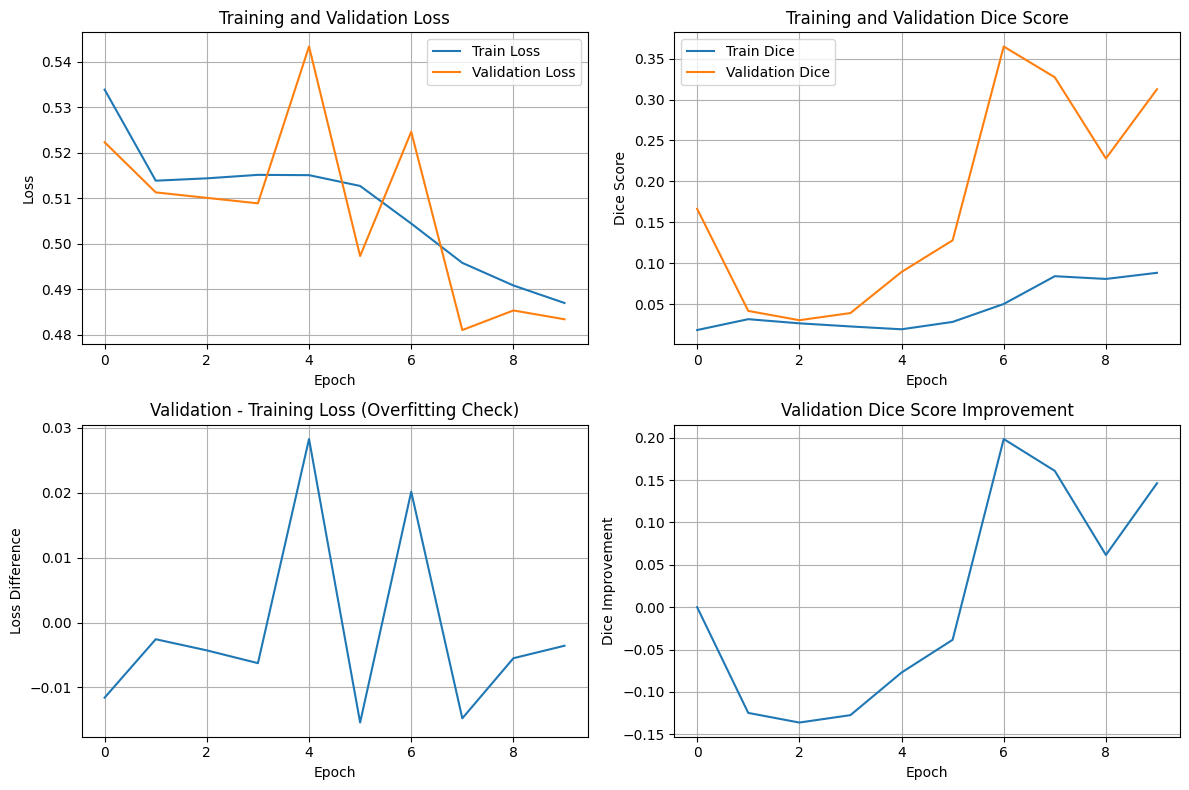

[Sample 0] True mask unique values: [0 1 2]
[Sample 1] True mask unique values: [0 1 2]
[Sample 2] True mask unique values: [0]
[Sample 3] True mask unique values: [0 2]
[Sample 4] True mask unique values: [0]


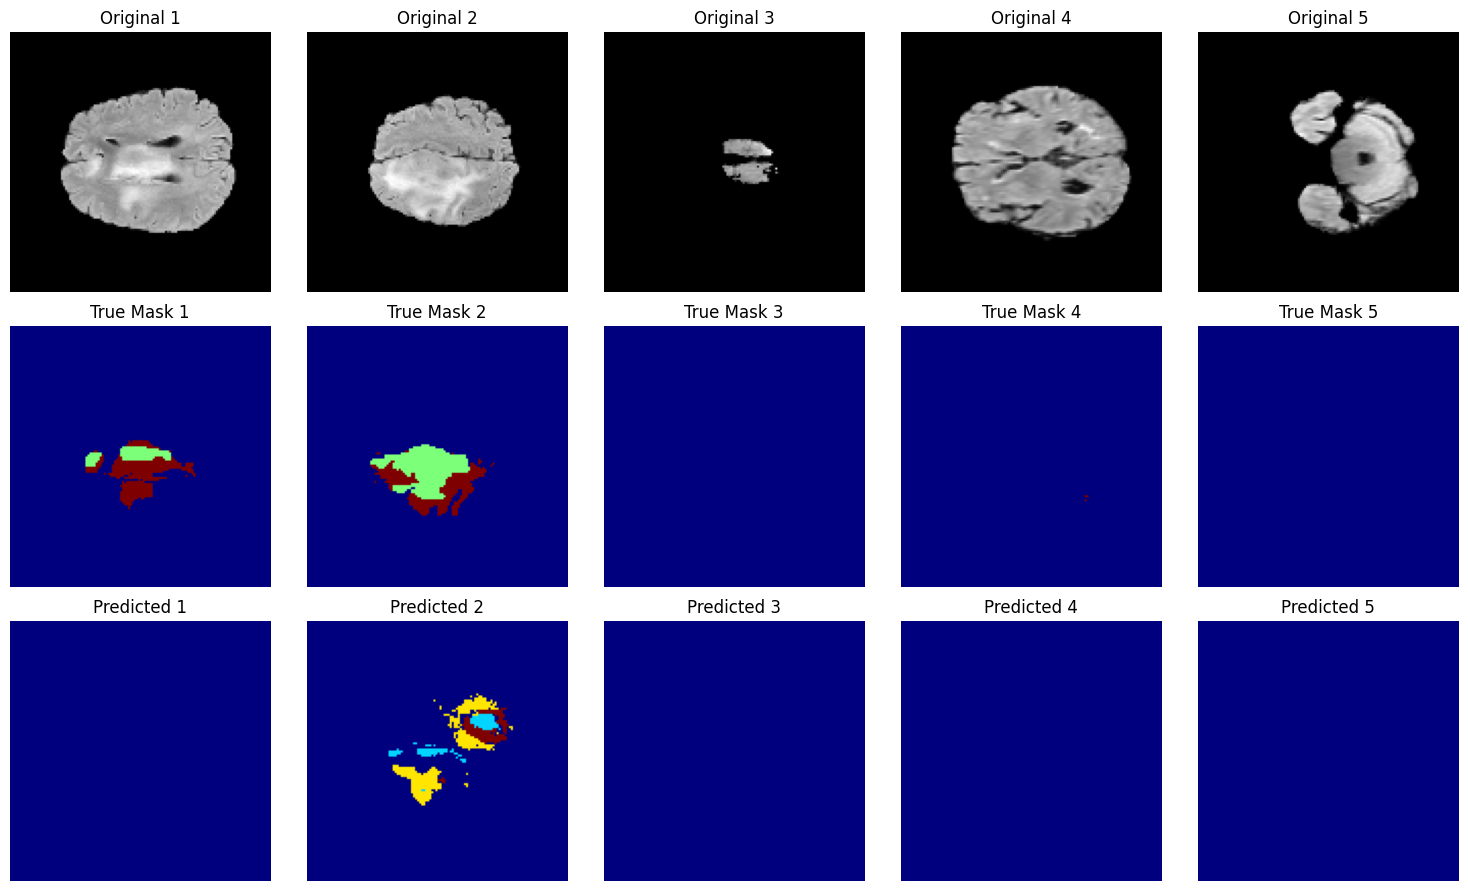

💾 Final model saved at: /content/drive/MyDrive/resnet120_lstm_brain_tumor_final.pth
Training completed successfully!


In [21]:

def main():
    """Main execution function"""
    print("Starting Brain Tumor Segmentation Training...")

    # First, explore dataset structure
    train_path, patient_folders = explore_dataset_structure()

    if not train_path or not patient_folders:
        print("ERROR: Could not find proper dataset structure!")
        print("Please check that the BraTS dataset is properly added to your Kaggle notebook.")
        return

    # Load and preprocess data
    print("\nLoading and preprocessing data...")
    data_loader = BraTSDataLoader(
        data_path=train_path,
        subset_size=10
    )

    if not data_loader.patient_folders:
        print("ERROR: No patient folders found!")
        return

    sequences, masks = data_loader.create_dataset()
    print(f"Dataset created: {sequences.shape} sequences, {masks.shape} masks")

    if len(sequences) == 0:
        print("ERROR: No data loaded!")
        print("This might be due to:")
        print("1. Incorrect file naming pattern")
        print("2. Missing modality files")
        print("3. Empty/corrupt data files")
        return

    print("SUCCESS: Data loaded successfully!")
    print(f"Total sequences: {len(sequences)}")
    print(f"Sequence shape: {sequences[0].shape}")
    print(f"Mask shape: {masks[0].shape}")

    # If we reach here, data loading works - continue with training
    # For now, let's just test with a tiny dataset
    if len(sequences) < 10 or sequences.shape[0] < 8:
        print("❗ Not enough sequences for training. Increase subset_size or reduce sequence_length.")
        return
        # print(f"Warning: Only {len(sequences)} sequences available. Need more data for proper training.")
        # print("Consider increasing subset_size or checking data quality.")
        # return

    # Create train/validation split
    train_sequences, val_sequences, train_masks, val_masks = train_test_split(
        sequences, masks, test_size=0.2, random_state=42
    )

    # Create datasets and dataloaders
    train_dataset = BraTSDataset(train_sequences, train_masks, sequence_length=8)
    val_dataset = BraTSDataset(val_sequences, val_masks, sequence_length=8)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    print(" Checking unique values in validation masks:")
    for i in range(5):
        _, true_mask = val_dataset[i]
        print(f"[Sample {i}] Unique labels in mask:", np.unique(true_mask.numpy()))

    # Initialize model
    model = ResNet120LSTM(input_channels=2, num_classes=4, pretrained=False)

    # Train model
    print("Starting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=10
        ,
        learning_rate=0.001,
        checkpoint_dir='/content/drive/MyDrive/brain_tumor_checkpoints'
    )
    print("Training resumed from epoch:", history.get('resume_epoch', 0))
    # Plot results
    plot_training_curves(history)

    # Visualize some results
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    visualize_results(model, val_dataset, device, num_samples=5)

    # Save model
    model_path = '/content/drive/MyDrive/resnet120_lstm_brain_tumor_final.pth'
    torch.save(model.state_dict(), model_path)
    print(f" Final model saved at: {model_path}")
    evaluate_segmentation_metrics(model, val_loader, device)
    print("Training completed successfully!")


# Run the main function
if __name__ == "__main__":
    main()

In [22]:
!pip install medpy

In [23]:
from sklearn.metrics import confusion_matrix
from medpy.metric.binary import hd95

# Helper: Binary Dice score
def dice_score(pred_mask, true_mask, smooth=1e-5):
    intersection = np.sum(pred_mask * true_mask)
    return (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask) + smooth)

# Helper: Compute per-class Dice
def compute_per_class_dice(pred, target):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    results = {}

    # Whole Tumor (WT): 1, 2, 3
    results['WT_Dice'] = dice_score((pred > 0), (target > 0))

    # Tumor Core (TC): 1, 3
    results['TC_Dice'] = dice_score(np.isin(pred, [1, 3]), np.isin(target, [1, 3]))

    # Enhancing Tumor (ET): 3
    results['ET_Dice'] = dice_score((pred == 3), (target == 3))

    return results

# Helper: Hausdorff 95 distance
def compute_hausdorff(pred, target, class_id):
    pred_bin = (pred == class_id).cpu().numpy().astype(np.uint8)
    target_bin = (target == class_id).cpu().numpy().astype(np.uint8)
    if np.sum(pred_bin) == 0 or np.sum(target_bin) == 0:
        return np.nan  # return NaN for empty class
    return hd95(pred_bin, target_bin)

# Helper: Confusion Matrix
def compute_confusion(pred, target):
    pred_flat = pred.view(-1).cpu().numpy()
    target_flat = target.view(-1).cpu().numpy()
    return confusion_matrix(target_flat, pred_flat, labels=[0, 1, 2, 3])


In [24]:
def evaluate_segmentation_metrics(model, val_loader, device):
    model.eval()

    dice_list = {'WT_Dice': [], 'TC_Dice': [], 'ET_Dice': []}
    hd_list = {1: [], 2: [], 3: []}  # per class ID
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for sequences, masks in tqdm(val_loader, desc="Evaluating metrics"):
            sequences, masks = sequences.to(device), masks.to(device)
            outputs = model(sequences)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

            for i in range(preds.shape[0]):
                p = preds[i]
                t = masks[i]

                # Per-class Dice
                d = compute_per_class_dice(p, t)
                for k in dice_list:
                    dice_list[k].append(d[k])

                # Hausdorff
                for class_id in [1, 2, 3]:
                    h = compute_hausdorff(p, t, class_id)
                    if not np.isnan(h):
                        hd_list[class_id].append(h)

                # Confusion matrix
                all_preds.append(p.cpu().view(-1))
                all_targets.append(t.cpu().view(-1))

    # Dice averages
    avg_dice = {k: np.nanmean(v) for k, v in dice_list.items()}
    print(" Per-Class Dice:")
    for k, v in avg_dice.items():
        print(f"  {k}: {v:.4f}")

    # Hausdorff averages
    print("\n📏 Hausdorff Distance (95%) per class:")
    for class_id, v in hd_list.items():
        if v:
            print(f"  Class {class_id}: {np.nanmean(v):.2f} pixels")

    # Confusion matrix
    pred_all = torch.cat(all_preds)
    true_all = torch.cat(all_targets)
    cm = compute_confusion(pred_all, true_all)
    print("\n Confusion Matrix [0=BG, 1=NCR, 2=ED, 3=ET]:")
    print(cm)
